<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/main/XGboost_Ele_Power_Consumption_Forecasting_Student_ID_21072112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [ ]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [ ]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

Date      Time Global_active_power Global_reactive_power  \
0        16/12/2006  17:24:00               4.216                 0.418   
1        16/12/2006  17:25:00               5.360                 0.436   
2        16/12/2006  17:26:00               5.374                 0.498   
3        16/12/2006  17:27:00               5.388                 0.502   
4        16/12/2006  17:28:00               3.666                 0.528   
...             ...       ...                 ...                   ...   
2075254  26/11/2010  20:58:00               0.946                   0.0   
2075255  26/11/2010  20:59:00               0.944                   0.0   
2075256  26/11/2010  21:00:00               0.938                   0.0   
2075257  26/11/2010  21:01:00               0.934                   0.0   
2075258  26/11/2010  21:02:00               0.932                   0.0   

         Voltage Global_intensity Sub_metering_1 Sub_metering_2  \
0        234.840           18.400          0.000          1.000   
1        233.630           23.000          0.000          1.000   
2        233.290           23.000          0.000          2.000   
3        233.740           23.000          0.000          1.000   
4        235.680           15.800          0.000          1.000   
...          ...              ...            ...            ...   
2075254   240.43              4.0            0.0            0.0   
2075255    240.0              4.0            0.0            0.0   
2075256   239.82              3.8            0.0            0.0   
2075257    239.7              3.8            0.0            0.0   
2075258   239.55              3.8            0.0            0.0   

         Sub_metering_3  
0                  17.0  
1                  16.0  
2                  17.0  
3                  17.0  
4                  17.0  
...                 ...  
2075254             0.0  
2075255             0.0  
2075256             0.0  
2075257             0.0  
2075258             0.0  

[2075259 rows x 9 columns]

In [ ]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Data Preprocessing

In [ ]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [ ]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [ ]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Copy the original DataFrame into a new DataFrame
df_copy = df.copy()
df_copy

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
date_time                            
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0  
...                             ...  
2010-11-26 20:58:00             0.0  
2010-11-26 20:59:00             0.0  
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0  

[2075259 rows x 7 columns]

# Data Imputation

In [ ]:
# Check Missing Values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
# Apply MICE imputer
imputer = IterativeImputer(random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed, index=df.index, columns=df.columns)

# Fill NaN values using the mean for each column
#df_imputed = df.copy()
#df_imputed.fillna(df.mean(), inplace=True)

In [ ]:
# Check Missing Values after imputation
df_imputed.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [ ]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df_imputed['Global_active_power']*1000/60)
equation2 = df_imputed['Sub_metering_1'] + df_imputed['Sub_metering_2'] + df_imputed['Sub_metering_3']
df_imputed['Sub_metering_4'] = equation1 - equation2
df_imputed

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  Sub_metering_4  
date_time                                            
2006-12-16 17:24:00            17.0       52.266667  
2006-12-16 17:25:00            16.0       72.333333  
2006-12-16 17:26:00            17.0       70.566667  
2006-12-16 17:27:00            17.0       71.800000  
2006-12-16 17:28:00            17.0       43.100000  
...                             ...             ...  
2010-11-26 20:58:00             0.0       15.766667  
2010-11-26 20:59:00             0.0       15.733333  
2010-11-26 21:00:00             0.0       15.633333  
2010-11-26 21:01:00             0.0       15.566667  
2010-11-26 21:02:00             0.0       15.533333  

[2075259 rows x 8 columns]

# Hourly resampled data

In [ ]:
# Resampled the data
hourly_resampled = df_imputed.resample('H').mean()

# Save DataFrame to a CSV file
hourly_resampled.to_csv('hourly_resampled.csv')

## EDA

In [ ]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(df, resample_type, title):

  # Resample the data
  df_resampled = df.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))
  print('\n')

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(25,20))
  plt.suptitle("Visualization of %s Resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ Distribution Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ Correlation Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_resampled.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(200)
  plt.show()

Shape after Hourly resampling of data : (34589, 8) 




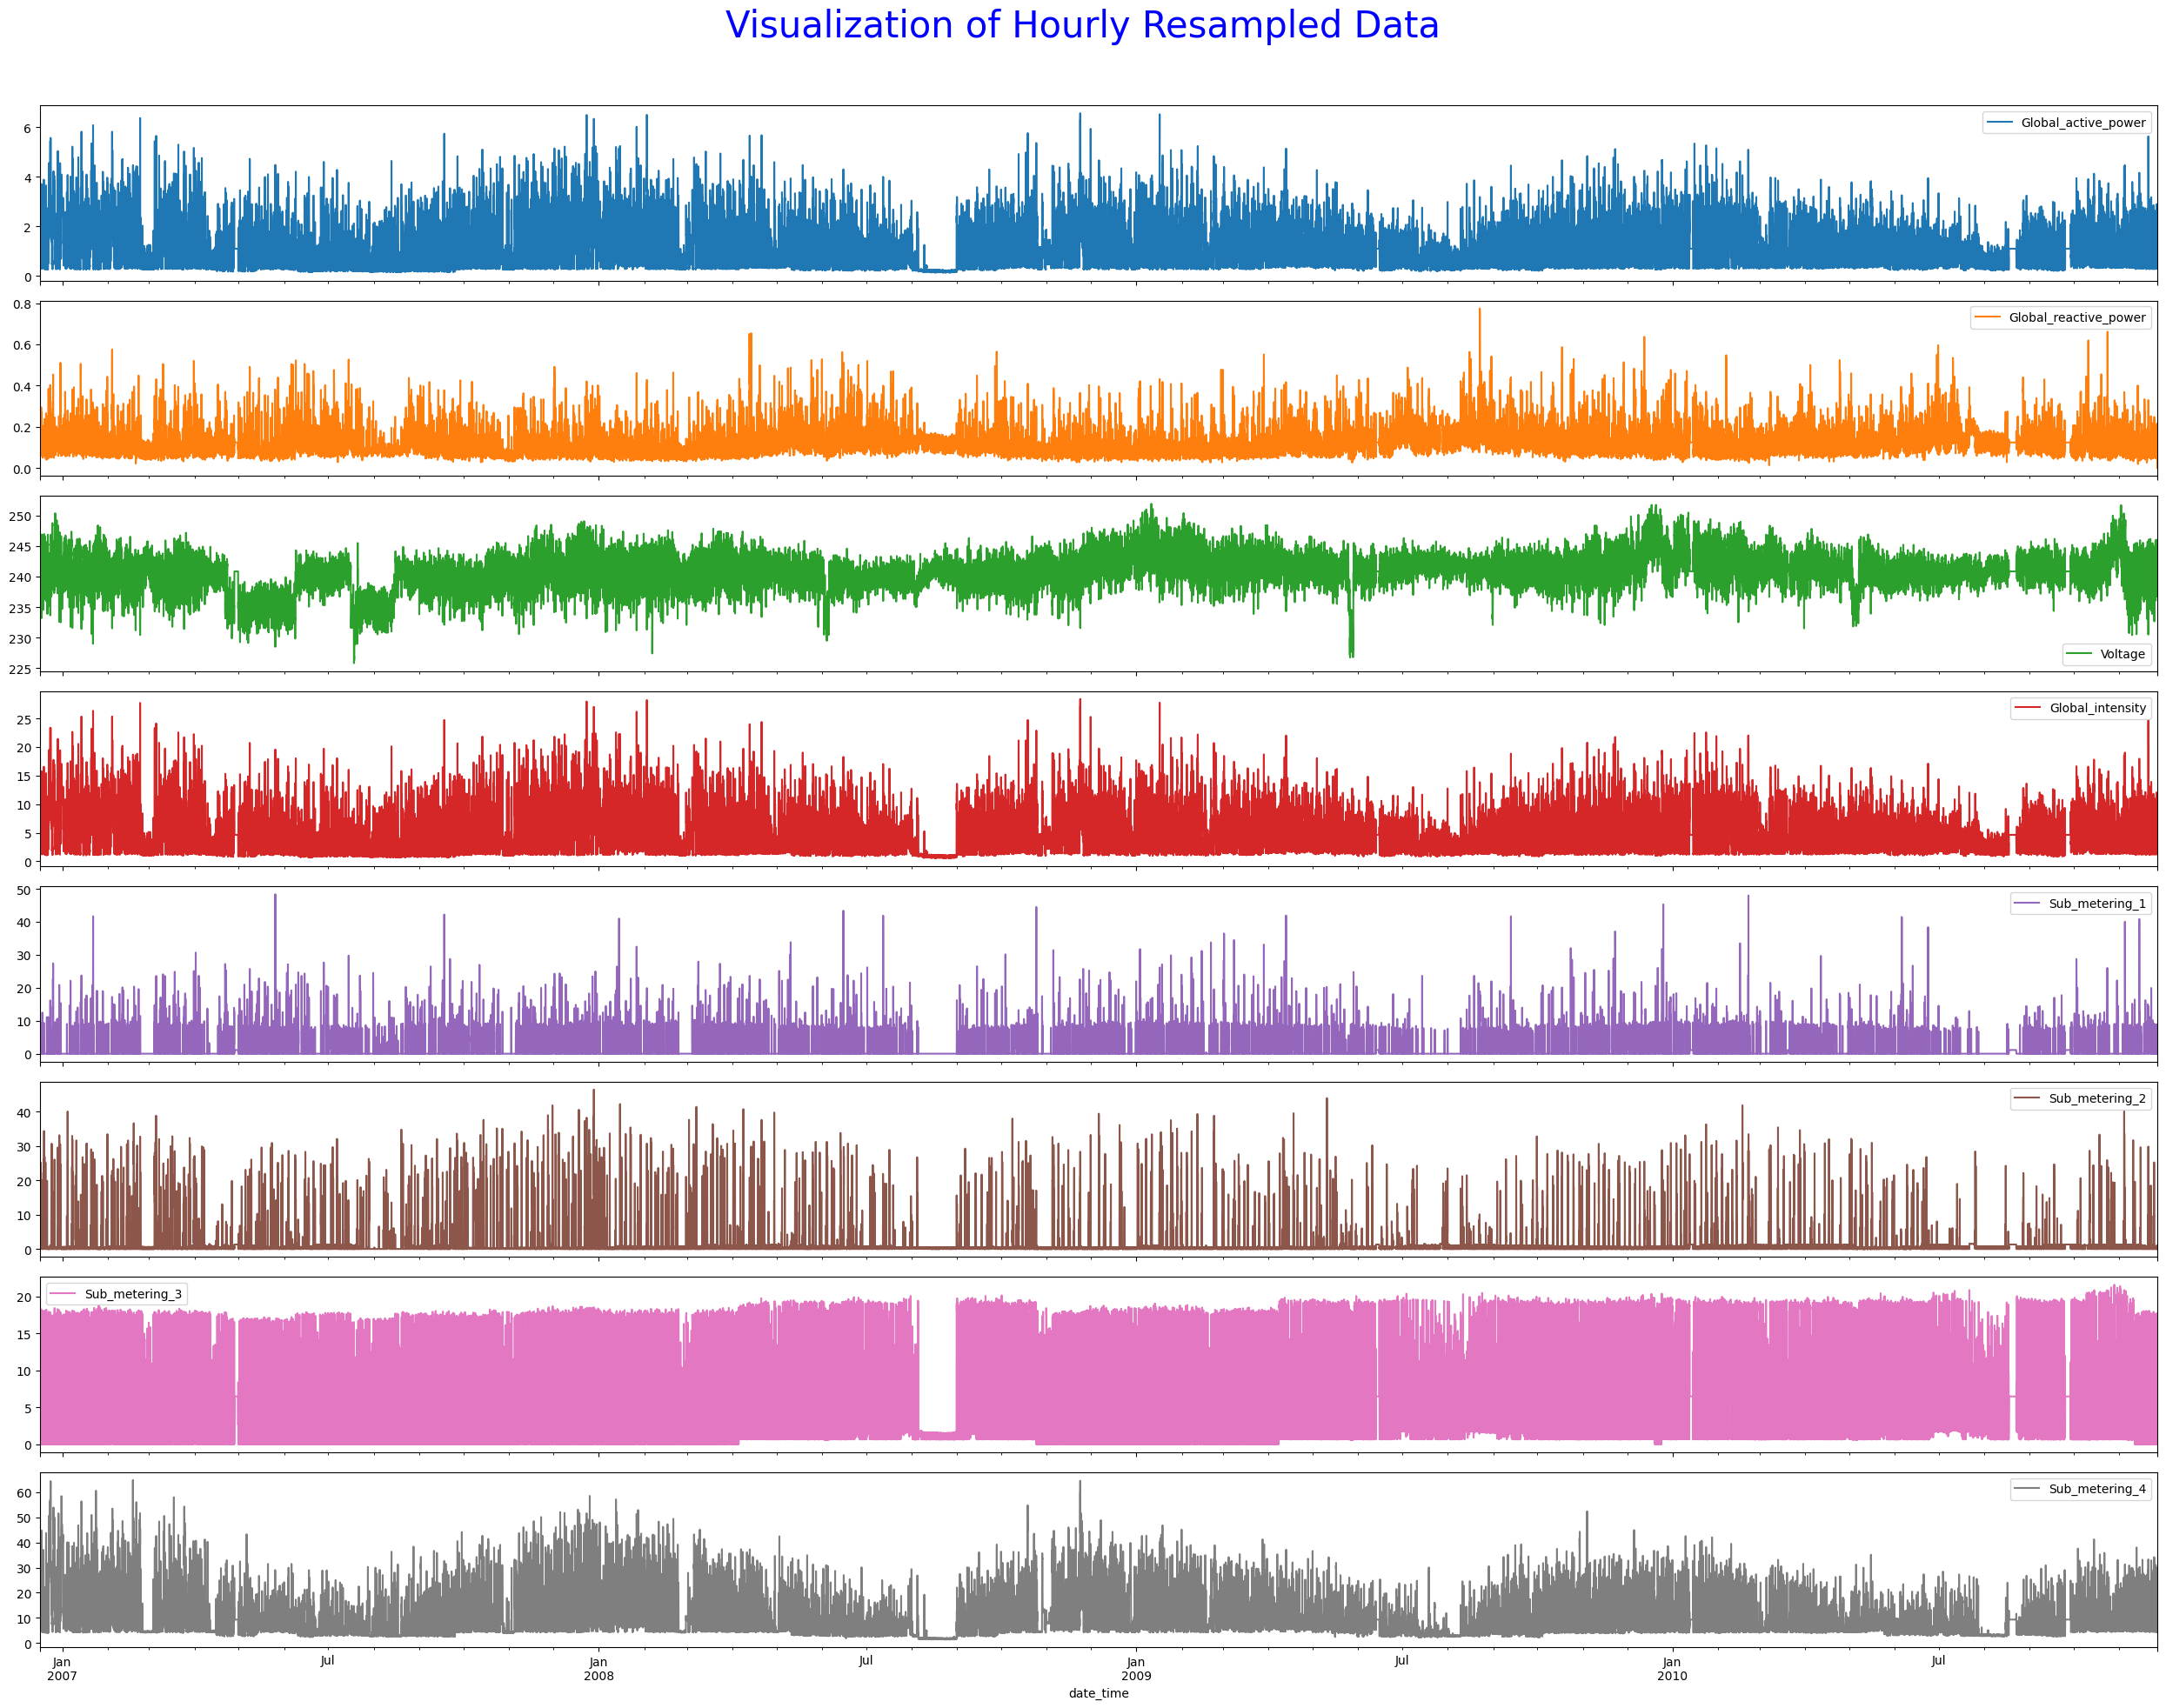

 

************************************************ Distribution Plot for Hourly Resampled Data **************************************************



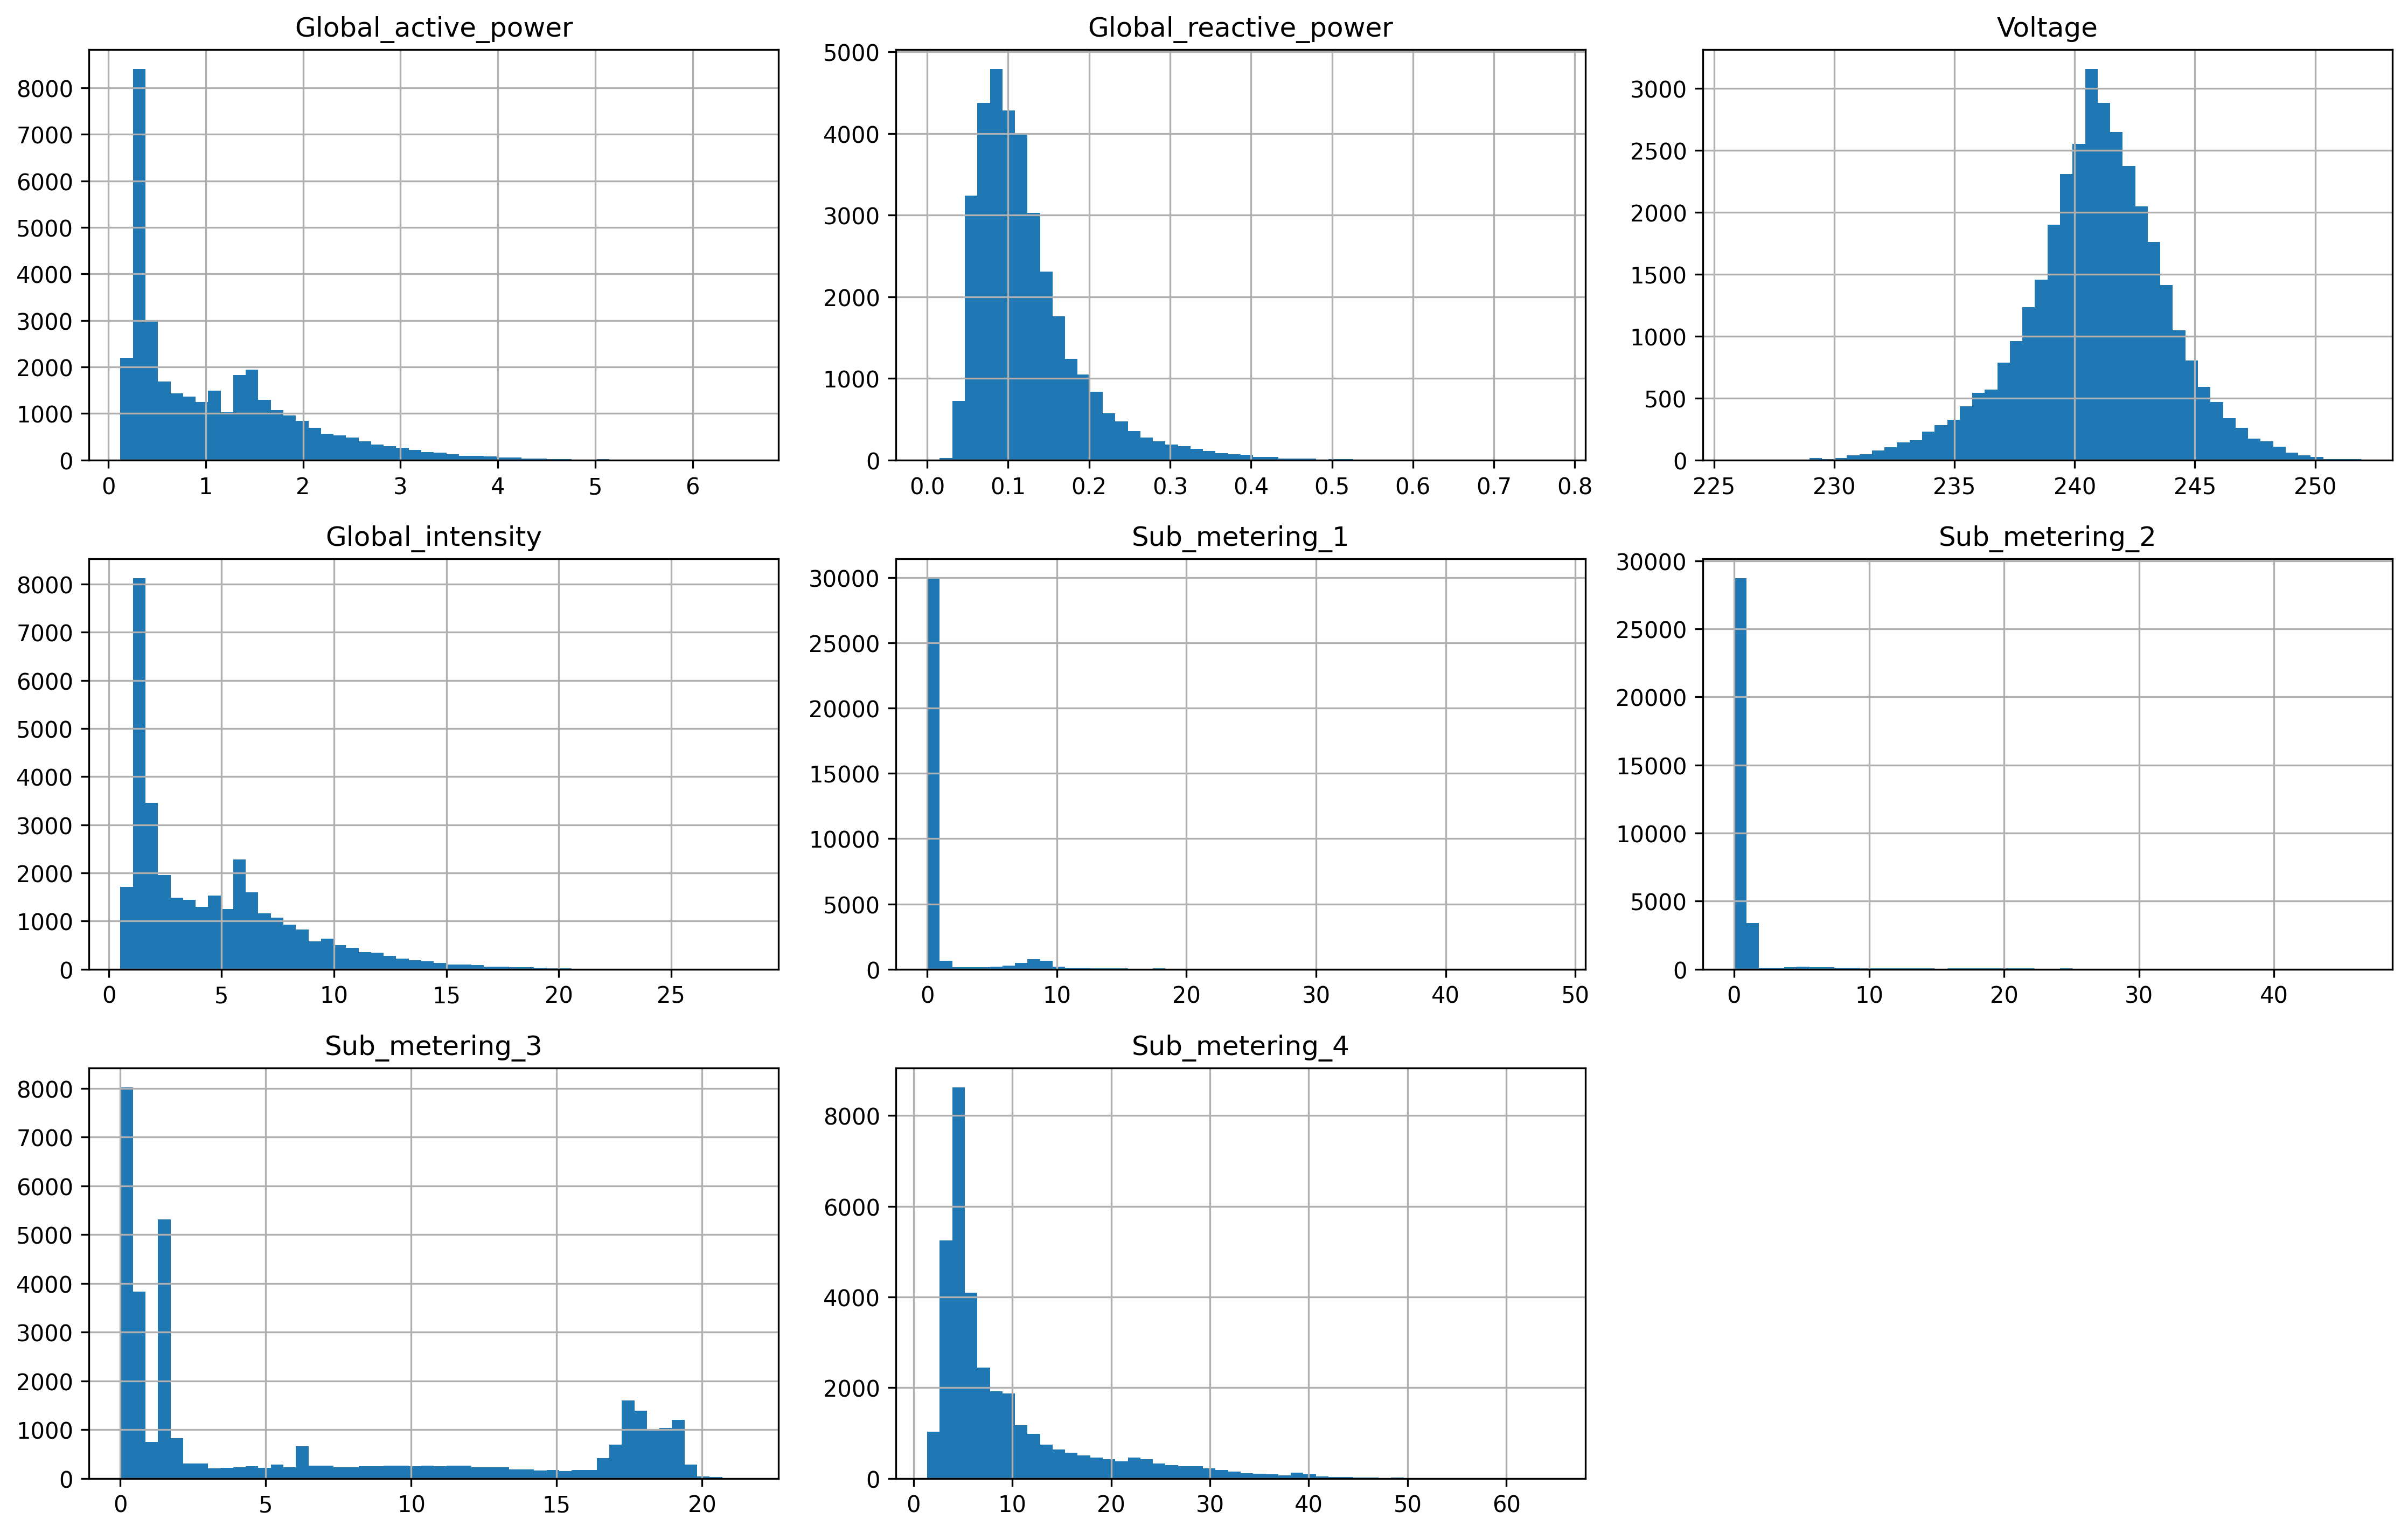

 

************************************************ Correlation Plot for Hourly Resampled Data **************************************************



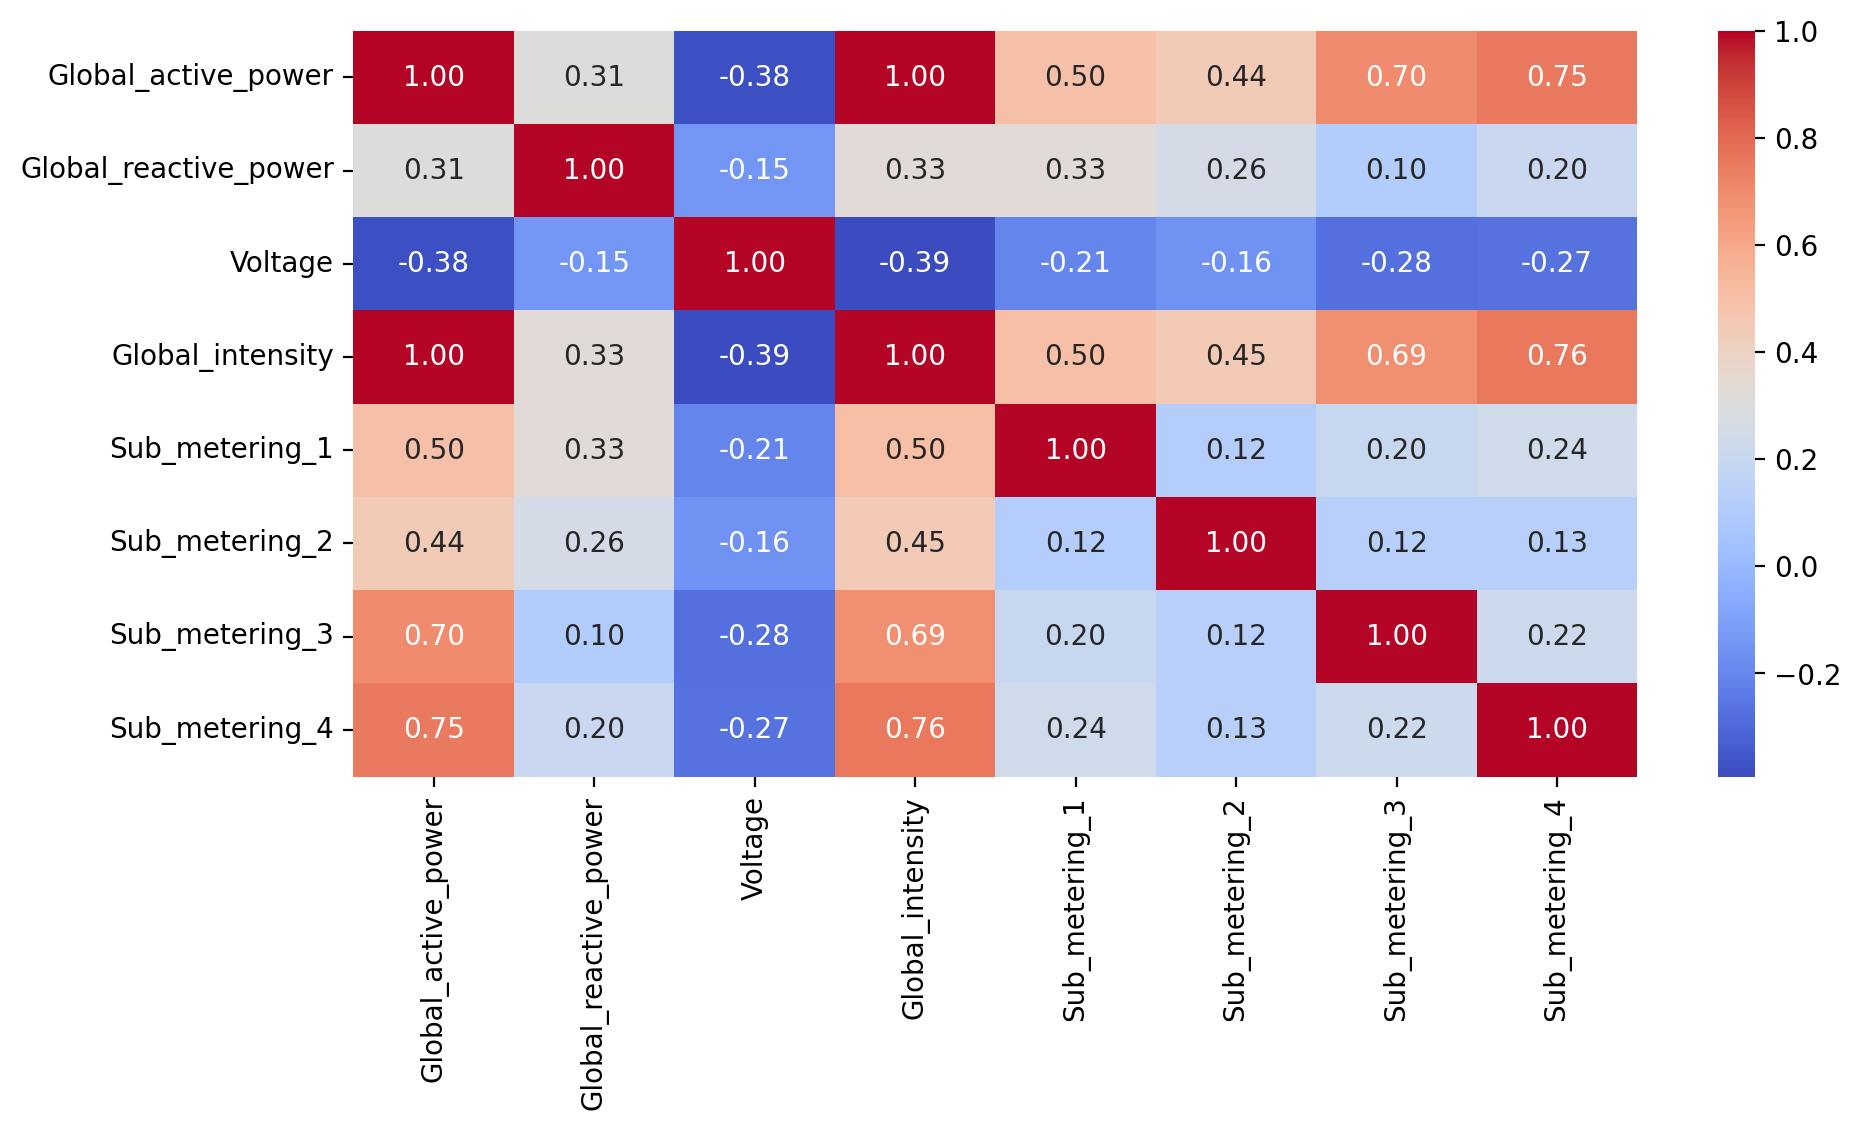

In [ ]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df_imputed, "H", "Hourly")

In [ ]:
# Remove the highly correlated columns
df1 = hourly_resampled.drop(['Global_intensity', 'Sub_metering_4'], axis=1)

## Feature Engineering

In [ ]:
# Create new columns for hour, day, quarter, month, and year
df1['hour'] = df1.index.hour
df1['month'] = df1.index.month
df1['quarter'] = df1.index.quarter
df1['year'] = df1.index.year
df1['week_of_year'] = df1.index.isocalendar().week
df1['day_of_week'] = df1.index.dayofweek
df1['day_of_month'] = df1.index.day
df1['day_of_year'] = df1.index.dayofyear
df1

Global_active_power  Global_reactive_power     Voltage  \
date_time                                                                     
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   
...                                  ...                    ...         ...   
2010-11-26 17:00:00             1.725900               0.061400  237.069667   
2010-11-26 18:00:00             1.573467               0.053700  237.531833   
2010-11-26 19:00:00             1.659333               0.060033  236.741000   
2010-11-26 20:00:00             1.163700               0.061167  239.396000   
2010-11-26 21:00:00             0.934667               0.000000  239.690000   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  hour  \
date_time                                                                   
2006-12-16 17:00:00             0.0        0.527778       16.861111    17   
2006-12-16 18:00:00             0.0        6.716667       16.866667    18   
2006-12-16 19:00:00             0.0        1.433333       16.683333    19   
2006-12-16 20:00:00             0.0        0.000000       16.783333    20   
2006-12-16 21:00:00             0.0        0.416667       17.216667    21   
...                             ...             ...             ...   ...   
2010-11-26 17:00:00             0.0        0.000000       12.866667    17   
2010-11-26 18:00:00             0.0        0.000000        0.000000    18   
2010-11-26 19:00:00             0.0        0.066667        0.000000    19   
2010-11-26 20:00:00             0.0        1.066667        0.000000    20   
2010-11-26 21:00:00             0.0        0.000000        0.000000    21   

                     month  quarter  year  week_of_year  day_of_week  \
date_time                                                              
2006-12-16 17:00:00     12        4  2006            50            5   
2006-12-16 18:00:00     12        4  2006            50            5   
2006-12-16 19:00:00     12        4  2006            50            5   
2006-12-16 20:00:00     12        4  2006            50            5   
2006-12-16 21:00:00     12        4  2006            50            5   
...                    ...      ...   ...           ...          ...   
2010-11-26 17:00:00     11        4  2010            47            4   
2010-11-26 18:00:00     11        4  2010            47            4   
2010-11-26 19:00:00     11        4  2010            47            4   
2010-11-26 20:00:00     11        4  2010            47            4   
2010-11-26 21:00:00     11        4  2010            47            4   

                     day_of_month  day_of_year  
date_time                                       
2006-12-16 17:00:00            16          350  
2006-12-16 18:00:00            16          350  
2006-12-16 19:00:00            16          350  
2006-12-16 20:00:00            16          350  
2006-12-16 21:00:00            16          350  
...                           ...          ...  
2010-11-26 17:00:00            26          330  
2010-11-26 18:00:00            26          330  
2010-11-26 19:00:00            26          330  
2010-11-26 20:00:00            26          330  
2010-11-26 21:00:00            26          330  

[34589 rows x 14 columns]

In [ ]:
# Show the columns and shape of final dataset
df1.columns, df1.shape

(Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
        'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'month',
        'quarter', 'year', 'week_of_year', 'day_of_week', 'day_of_month',
        'day_of_year'],
       dtype='object'),
 (34589, 14))

## Data Normalization

In [ ]:
# Initialize the Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_df1 = pd.DataFrame(scaler.fit_transform(df1), columns=df1.columns, index=df1.index)

# Shape of scaled data
scaled_df1.shape

(34589, 14)

## Train-Test Splitting

In [ ]:
# Split the data into Train & Test Split
target = ['Global_active_power']
features = scaled_df1.drop(columns=['Global_active_power']).columns

train_size = int(len(scaled_df1) * 0.80)
df1_train = scaled_df1[:train_size]
df1_test = scaled_df1[train_size:]

X_train = df1_train[features]
y_train = df1_train[target]
X_test = df1_test[features]
y_test = df1_test[target]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27671, 13), (27671, 1), (6918, 13), (6918, 1))

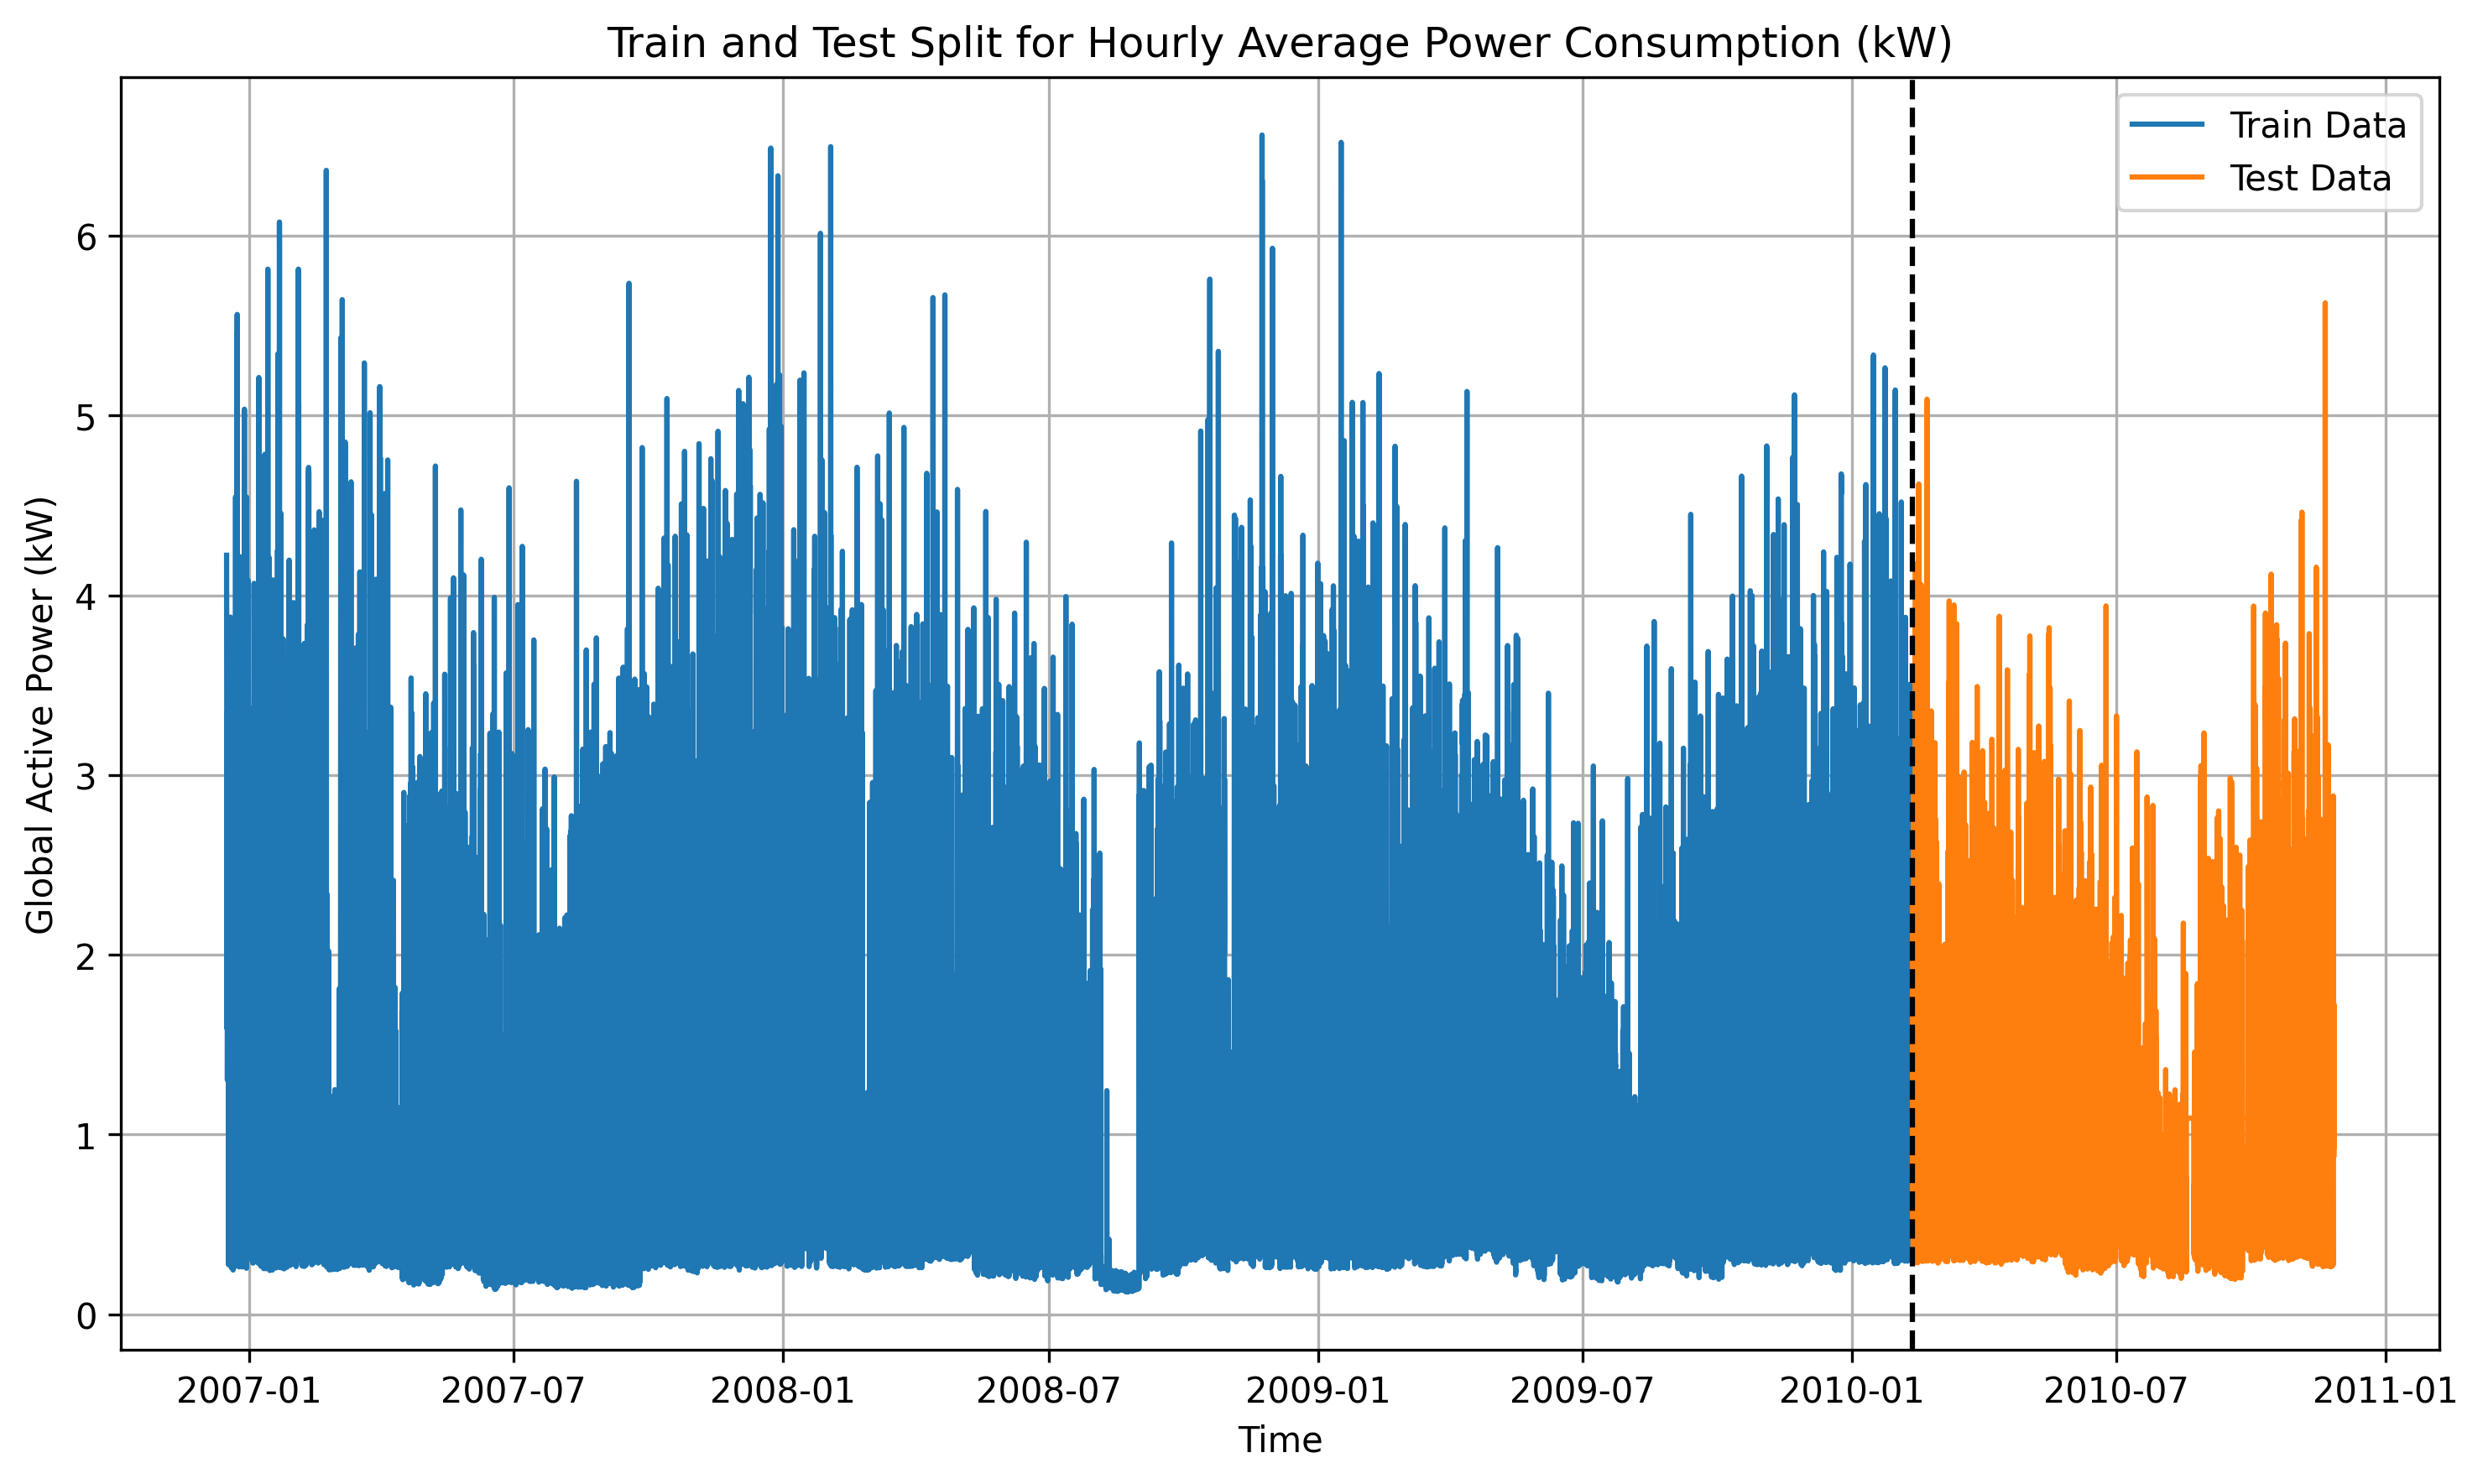

In [ ]:
# Plot train & test data
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(df1_train.Global_active_power, label='Train Data')
plt.plot(df1_test.Global_active_power, label='Test Data')
plt.axvline(df1_test.index[0], color='black', linestyle='--')
plt.title('Train and Test Split for Hourly Average Power Consumption (kW)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
df1.shape[-1], X_train.shape[-1]

(14, 13)

## Xgboost model with default parameters

[0]	validation_0-rmse:0.72247	validation_1-rmse:0.54381
[99]	validation_0-rmse:0.20476	validation_1-rmse:0.27121


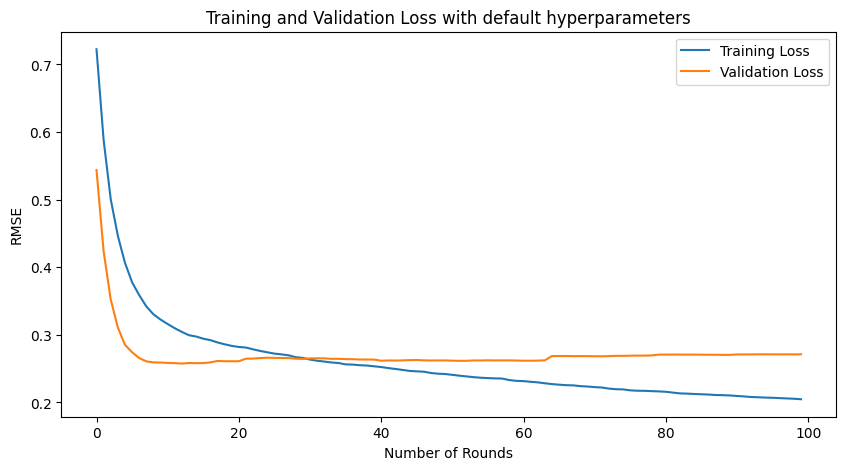


Train MAE: 0.137
Train MAPE: 0.176
Train MSE: 0.042
Train RMSE: 0.205

Test MAE: 0.186
Test MAPE: 0.235
Test MSE: 0.074
Test RMSE: 0.271


In [ ]:
# XGboost model with default parameters
xgb_model = xgb.XGBRegressor()

# Fit the XGboost model
history = xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

# Extract the evaluation results
evals_result = xgb_model.evals_result()

# Plot the training and validation loss with default parameters
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
plt.plot(evals_result['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss with default hyperparameters')
plt.legend()
plt.show()

# Predictions with the default model
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train, df1.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict.reshape(-1,1), df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test, df1.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for train data
test_prediction_copies = np.repeat(test_predict.reshape(-1,1), df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_train_y, pred_train_y):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_train_y, pred_train_y):.3f}')
print(f'Train MSE: {mean_squared_error(true_train_y, pred_train_y):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_train_y, pred_train_y)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_test_y, pred_test_y):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_test_y, pred_test_y):.3f}')
print(f'Test MSE: {mean_squared_error(true_test_y, pred_test_y):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_test_y, pred_test_y)):.3f}')

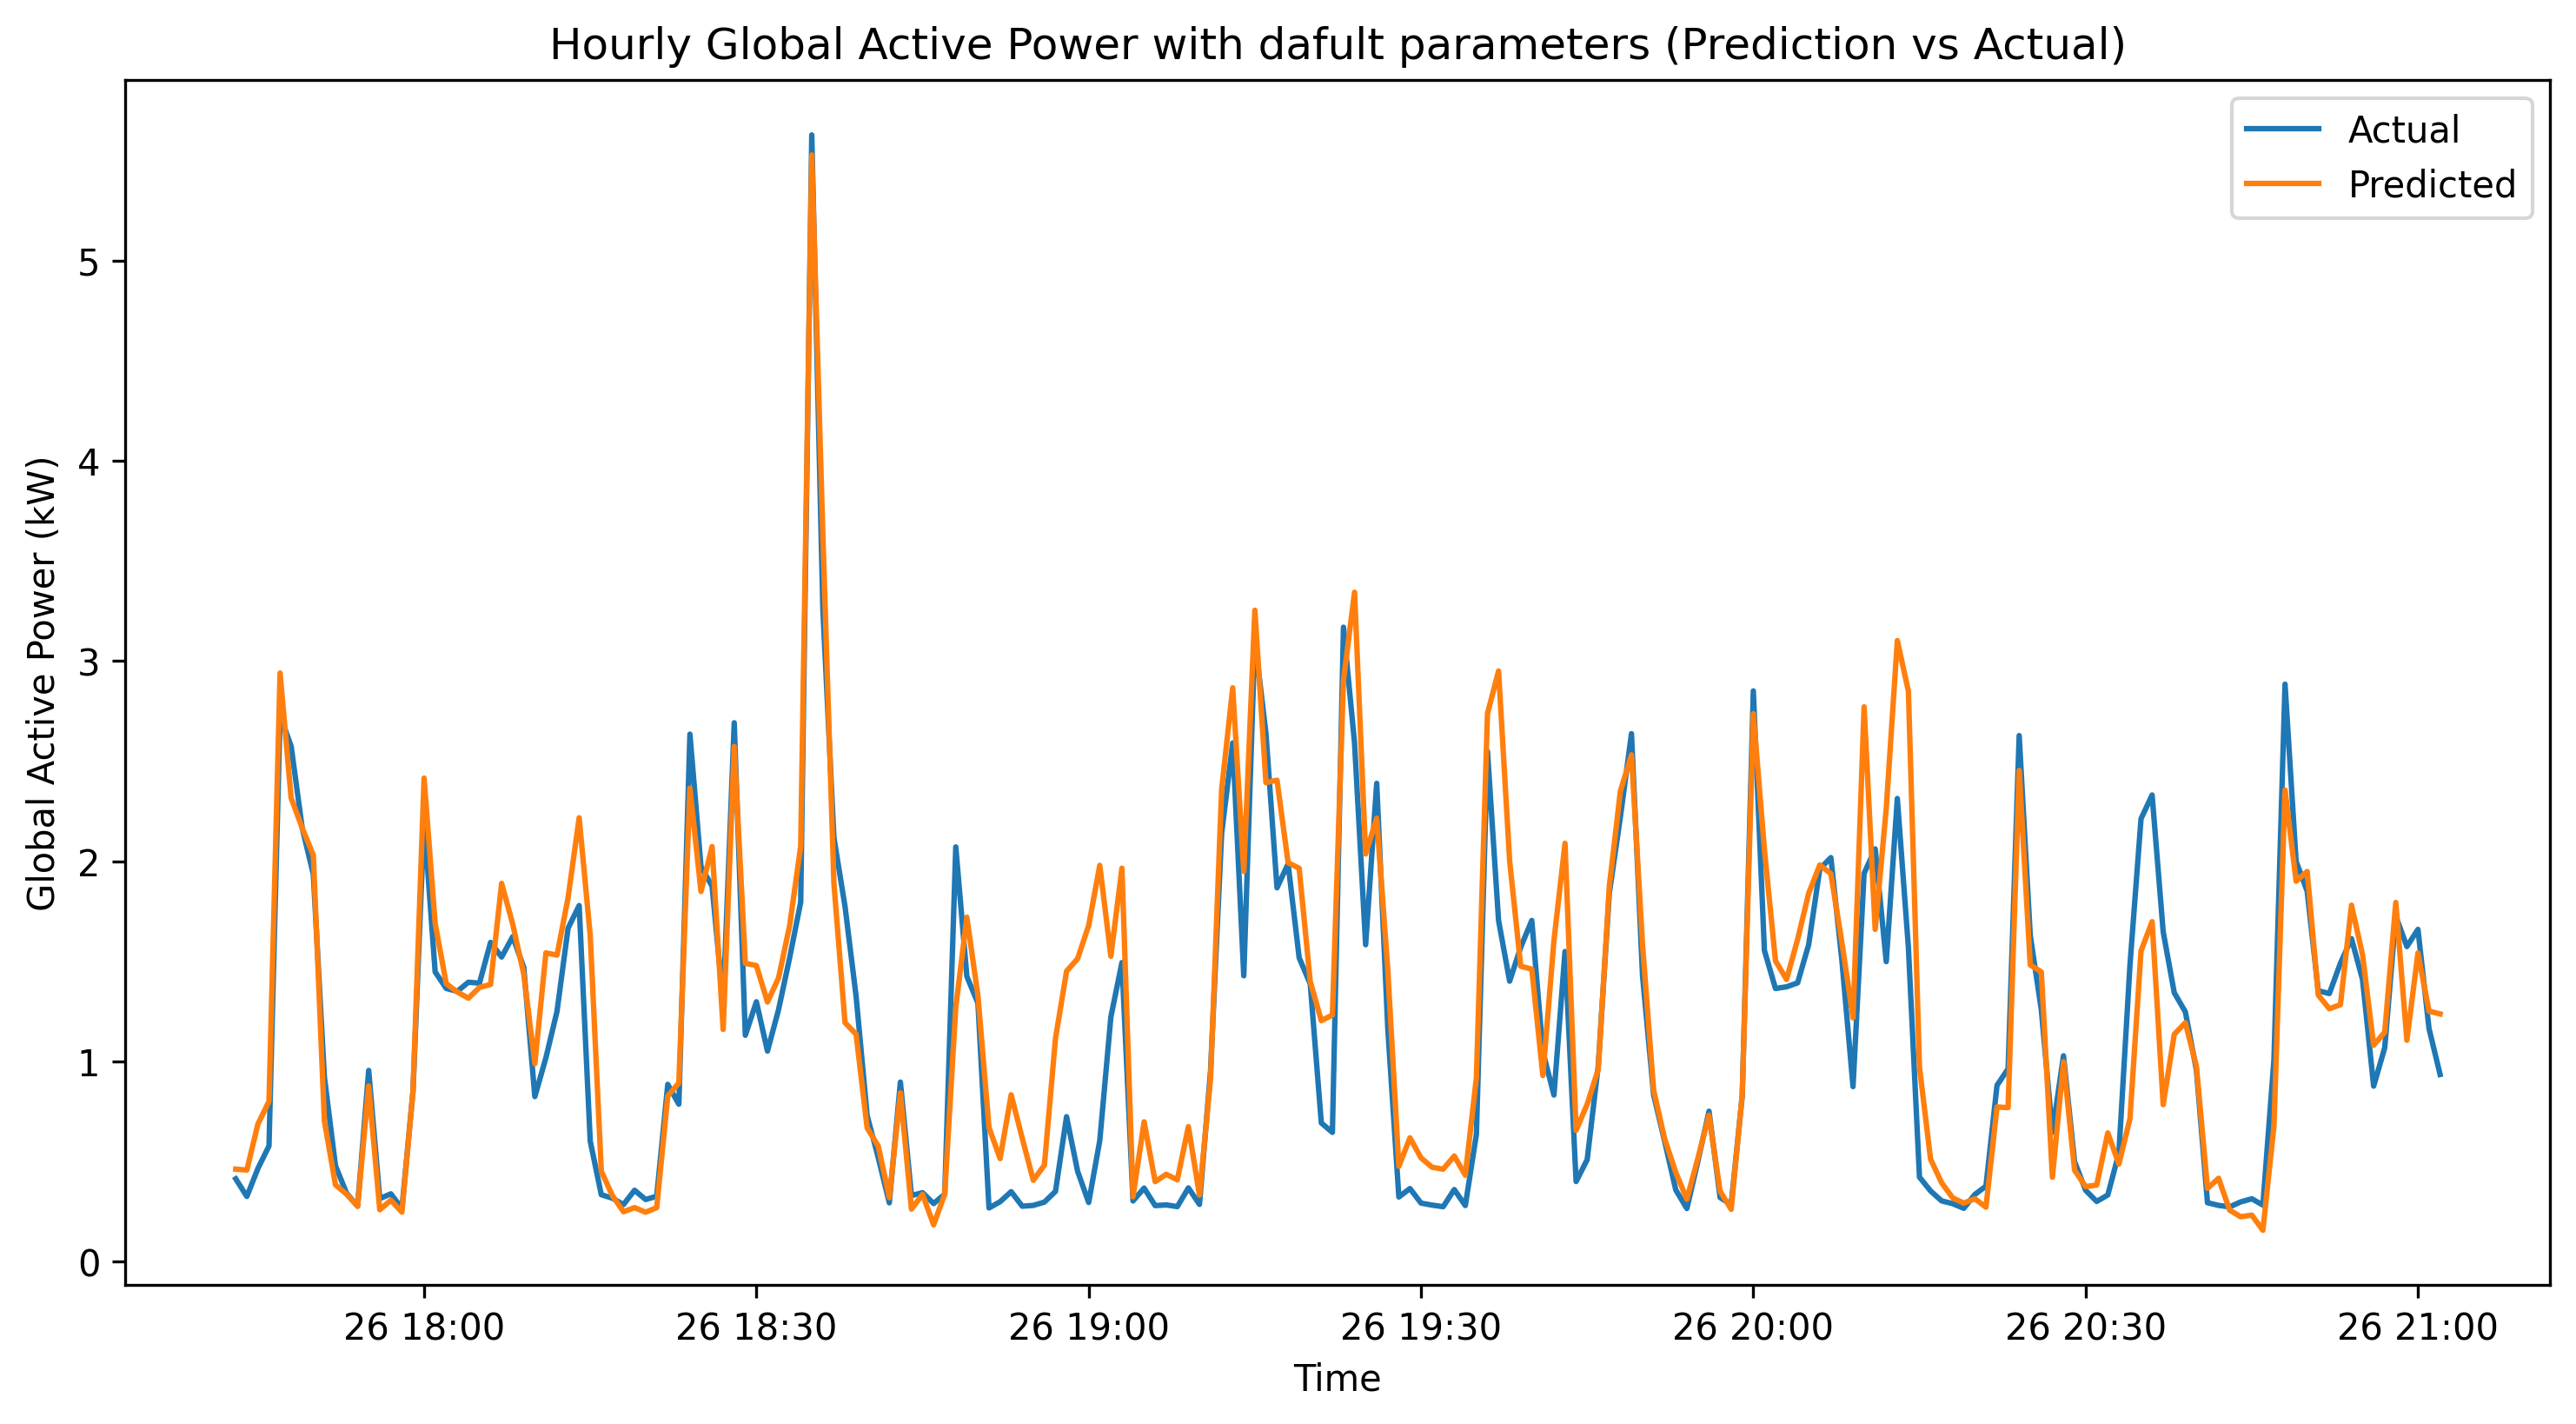

In [ ]:
# Plot the graph Actual vs Prediction
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df.index[-200:], y_test[-200:], label='Actual')
plt.plot(df.index[-200:], test_predict[-200:], label='Predicted')
plt.title('Hourly Global Active Power with dafult parameters (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## Fine-tuing of hyperparameters

## Grid Search-1 for optimal hyperparameters

In [ ]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameters
parameters_grid = {
    'n_estimators' : [1500, 2000, 2500],
    'learning_rate': [0.008, 0.01, 0.05],
    'max_depth': [4, 5, 6],
    'subsample': [0.3, 0.4, 0.5]
    }

# Set up Grid Search
grid_search = GridSearchCV(xgb_model, parameters_grid, scoring='neg_mean_squared_error', cv=7)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.008, 'max_depth': 6, 'n_estimators': 2000, 'subsample': 0.3}
Best score:  -0.11683085039733955


## Grid Search-2 for optimal hyperparameters

In [ ]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameters
parameters_grid = {
    'base_score' : [0.3, 0.4, 0.5],
    'min_split_loss' : [0, 0.5, 1],
    'min_child_weight' : [0, 1, 2],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'reg_lambda': [4, 5, 6],
    'reg_alpha' : [0, 1, 2]
    }

# Set up Grid Search
grid_search = GridSearchCV(xgb_model, parameters_grid, scoring='neg_mean_squared_error', cv=7)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'base_score': 0.5, 'colsample_bytree': 0.4, 'min_child_weight': 2, 'min_split_loss': 0, 'reg_alpha': 2, 'reg_lambda': 6}
Best score:  -0.12434227615606848


## XGBoost model with optimal hyperparameters

[0]	validation_0-rmse:1.10521	validation_1-rmse:0.87772
[100]	validation_0-rmse:0.70724	validation_1-rmse:0.53181
[200]	validation_0-rmse:0.50982	validation_1-rmse:0.37331
[300]	validation_0-rmse:0.41572	validation_1-rmse:0.30711
[400]	validation_0-rmse:0.36853	validation_1-rmse:0.28106
[500]	validation_0-rmse:0.34184	validation_1-rmse:0.26746
[600]	validation_0-rmse:0.32617	validation_1-rmse:0.26079
[700]	validation_0-rmse:0.31598	validation_1-rmse:0.25715
[800]	validation_0-rmse:0.30894	validation_1-rmse:0.25490
[900]	validation_0-rmse:0.30320	validation_1-rmse:0.25317
[1000]	validation_0-rmse:0.29920	validation_1-rmse:0.25239
[1100]	validation_0-rmse:0.29566	validation_1-rmse:0.25168
[1200]	validation_0-rmse:0.29241	validation_1-rmse:0.25113
[1300]	validation_0-rmse:0.28949	validation_1-rmse:0.25061
[1400]	validation_0-rmse:0.28674	validation_1-rmse:0.25018
[1500]	validation_0-rmse:0.28422	validation_1-rmse:0.25009
[1600]	validation_0-rmse:0.28176	validation_1-rmse:0.24997
[1700]	va

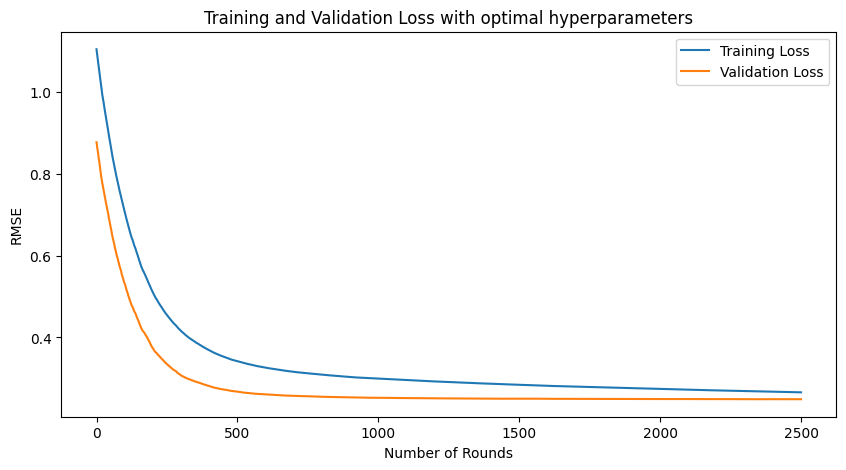


Train MAE: 0.174
Train MAPE: 0.216
Train MSE: 0.071
Train RMSE: 0.266

Test MAE: 0.165
Test MAPE: 0.200
Test MSE: 0.062
Test RMSE: 0.249


In [ ]:
# Define the XGBoost model with differnt hyperparameters
xgb_model = xgb.XGBRegressor(booster='gbtree',
                             base_score=0.5,
                             n_estimators=2000,
                             early_stopping_rounds=200,
                             objective='reg:linear',
                             max_depth=6,              # [default=6] range: [0,∞]
                             learning_rate=0.008,      # [default=0.3] range: [0,1]
                             min_child_weight=2,       # [default=1] range: [0,∞]
                             subsample=0.3,            # [default=1] range: [0,1]
                             colsample_bytree=0.4,     # [default=1] range: [0,1]
                             min_split_loss=0,         # [default=0] range: [0,∞]
                             reg_alpha=2,              # [default=0] range: [0,∞]
                             reg_lambda=6)             # [default=1] range: [0,∞]

# Fit the XGboost model
history = xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

# Extract the evaluation results
evals_result = xgb_model.evals_result()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
plt.plot(evals_result['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss with optimal hyperparameters')
plt.legend()
plt.show()

# Predictions with the fine-turned  model
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train, df1.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict.reshape(-1,1), df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test, df1.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for train data
test_prediction_copies = np.repeat(test_predict.reshape(-1,1), df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_train_y, pred_train_y):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_train_y, pred_train_y):.3f}')
print(f'Train MSE: {mean_squared_error(true_train_y, pred_train_y):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_train_y, pred_train_y)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_test_y, pred_test_y):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_test_y, pred_test_y):.3f}')
print(f'Test MSE: {mean_squared_error(true_test_y, pred_test_y):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_test_y, pred_test_y)):.3f}')

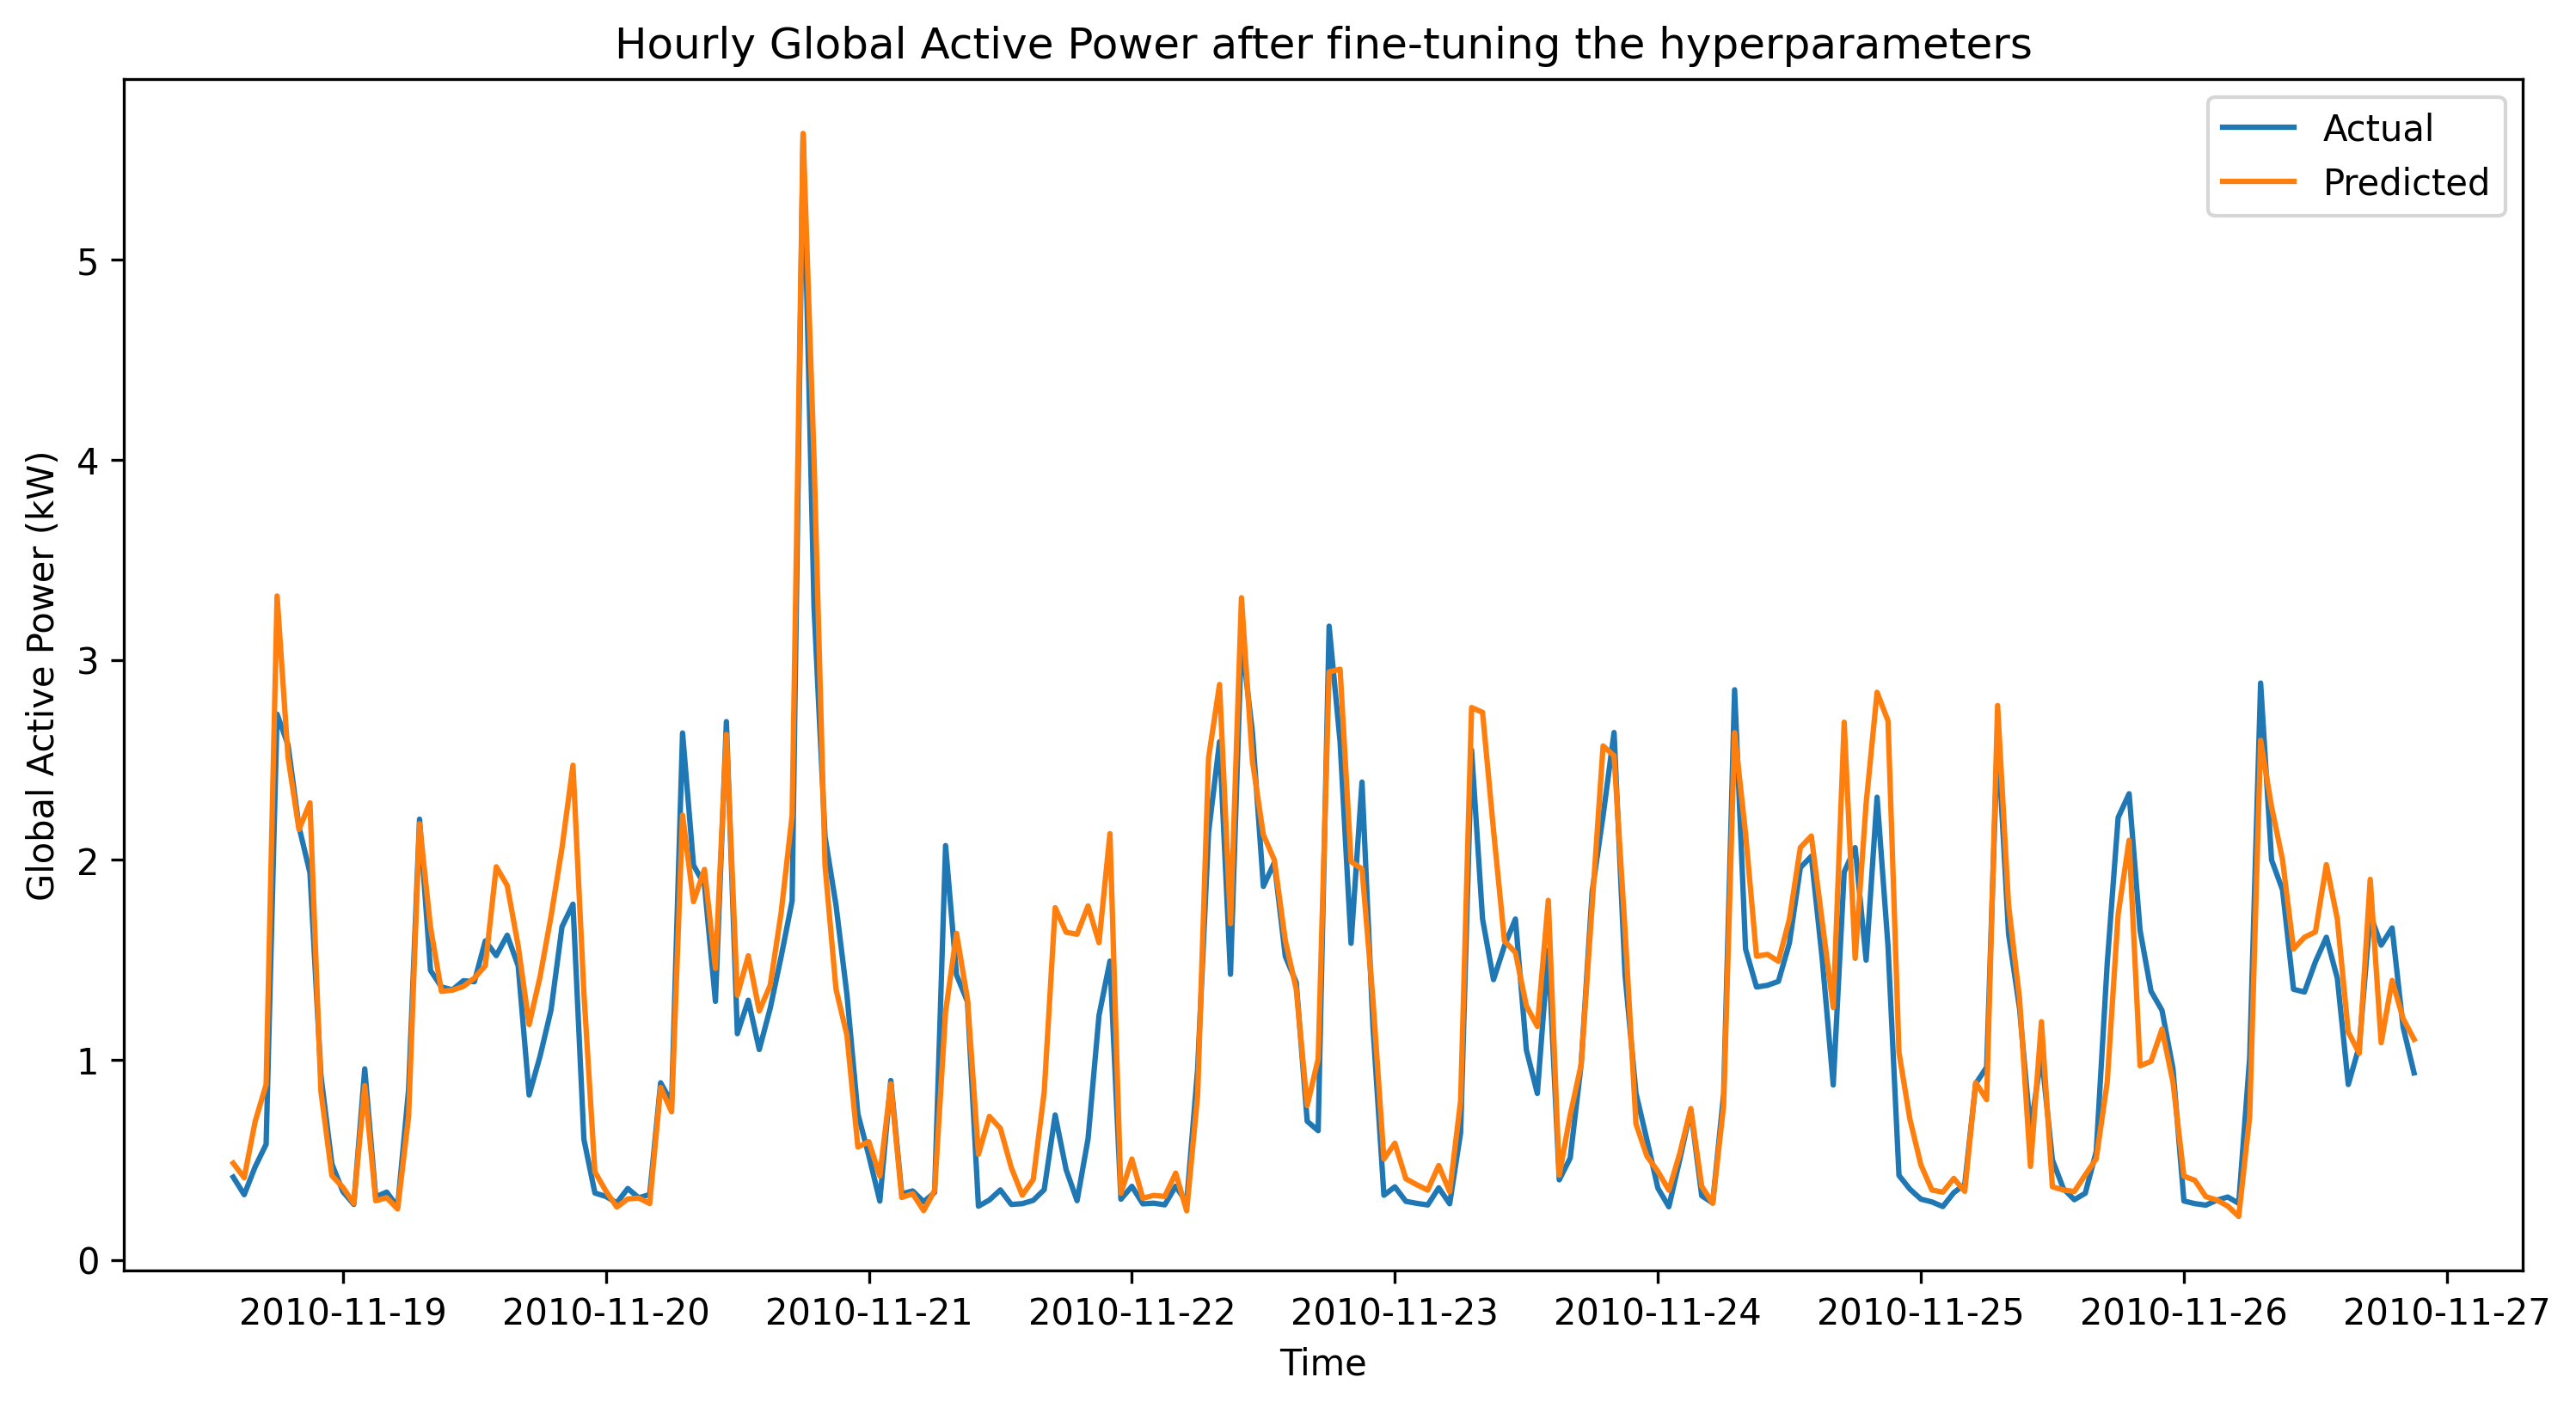

In [ ]:
# Plot the graph after fine-tuning the hyperparameters (Actual vs Prediction)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], test_predict[-200:], label='Predicted')
plt.title('Hourly Global Active Power after fine-tuning the hyperparameters')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## Feature Importance

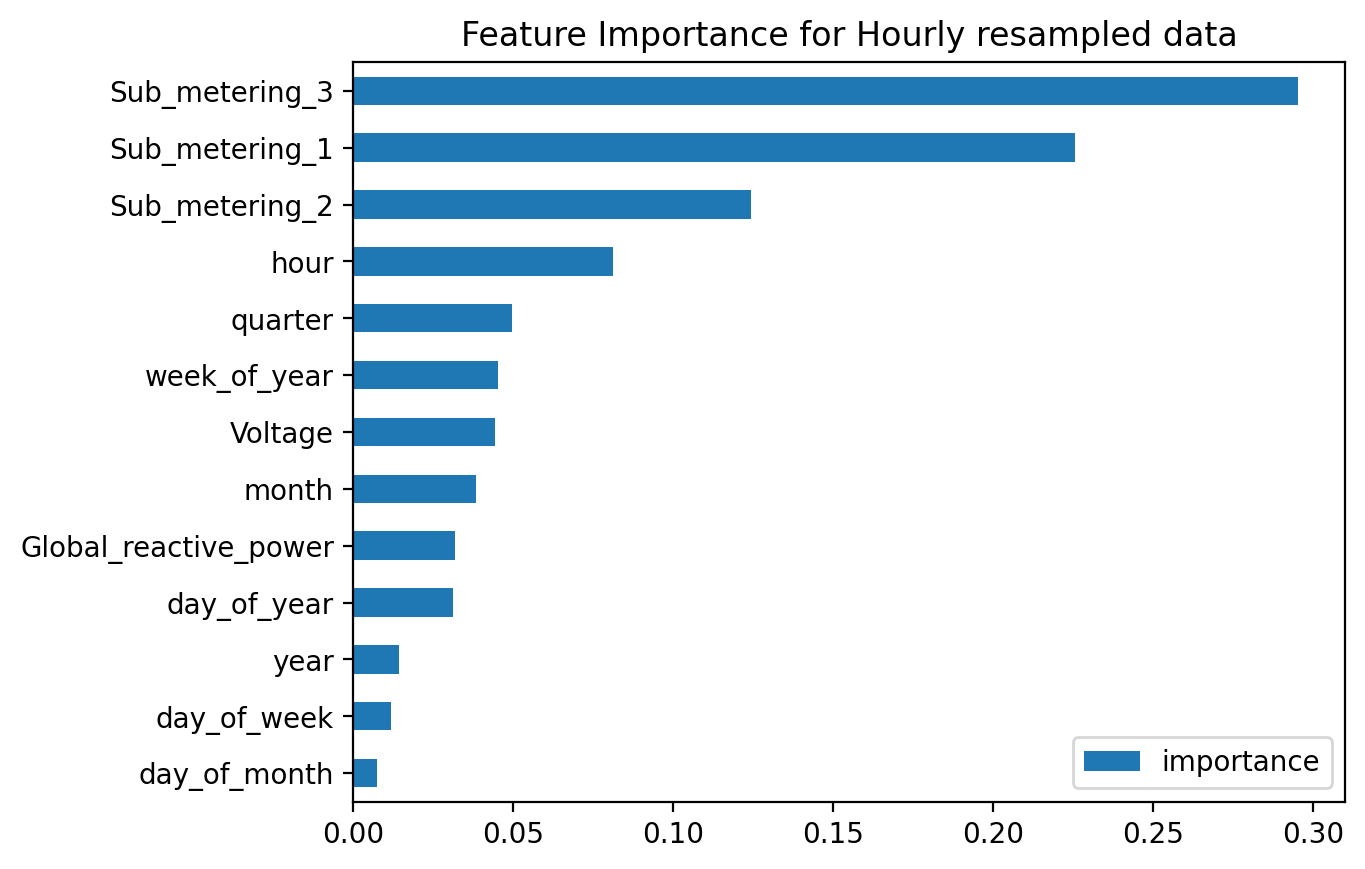

In [ ]:
# Feature Importance of XGBoost model
Feature_Imp = pd.DataFrame(data=xgb_model.feature_importances_,
                           index=xgb_model.feature_names_in_,
                           columns=['importance'])
Feature_Imp.sort_values('importance').plot(kind='barh', title='Feature Importance for Hourly resampled data')

# Plot the feature importance
plt.gcf().set_dpi(200)
plt.show()

# Daily resampled data

In [ ]:
# Resampled the data
daily_resampled = df_imputed.resample('D').mean()

# Save DataFrame to a CSV file
daily_resampled.to_csv('daily_resampled.csv')

## EDA

Shape after Daily resampling of data : (1442, 8) 




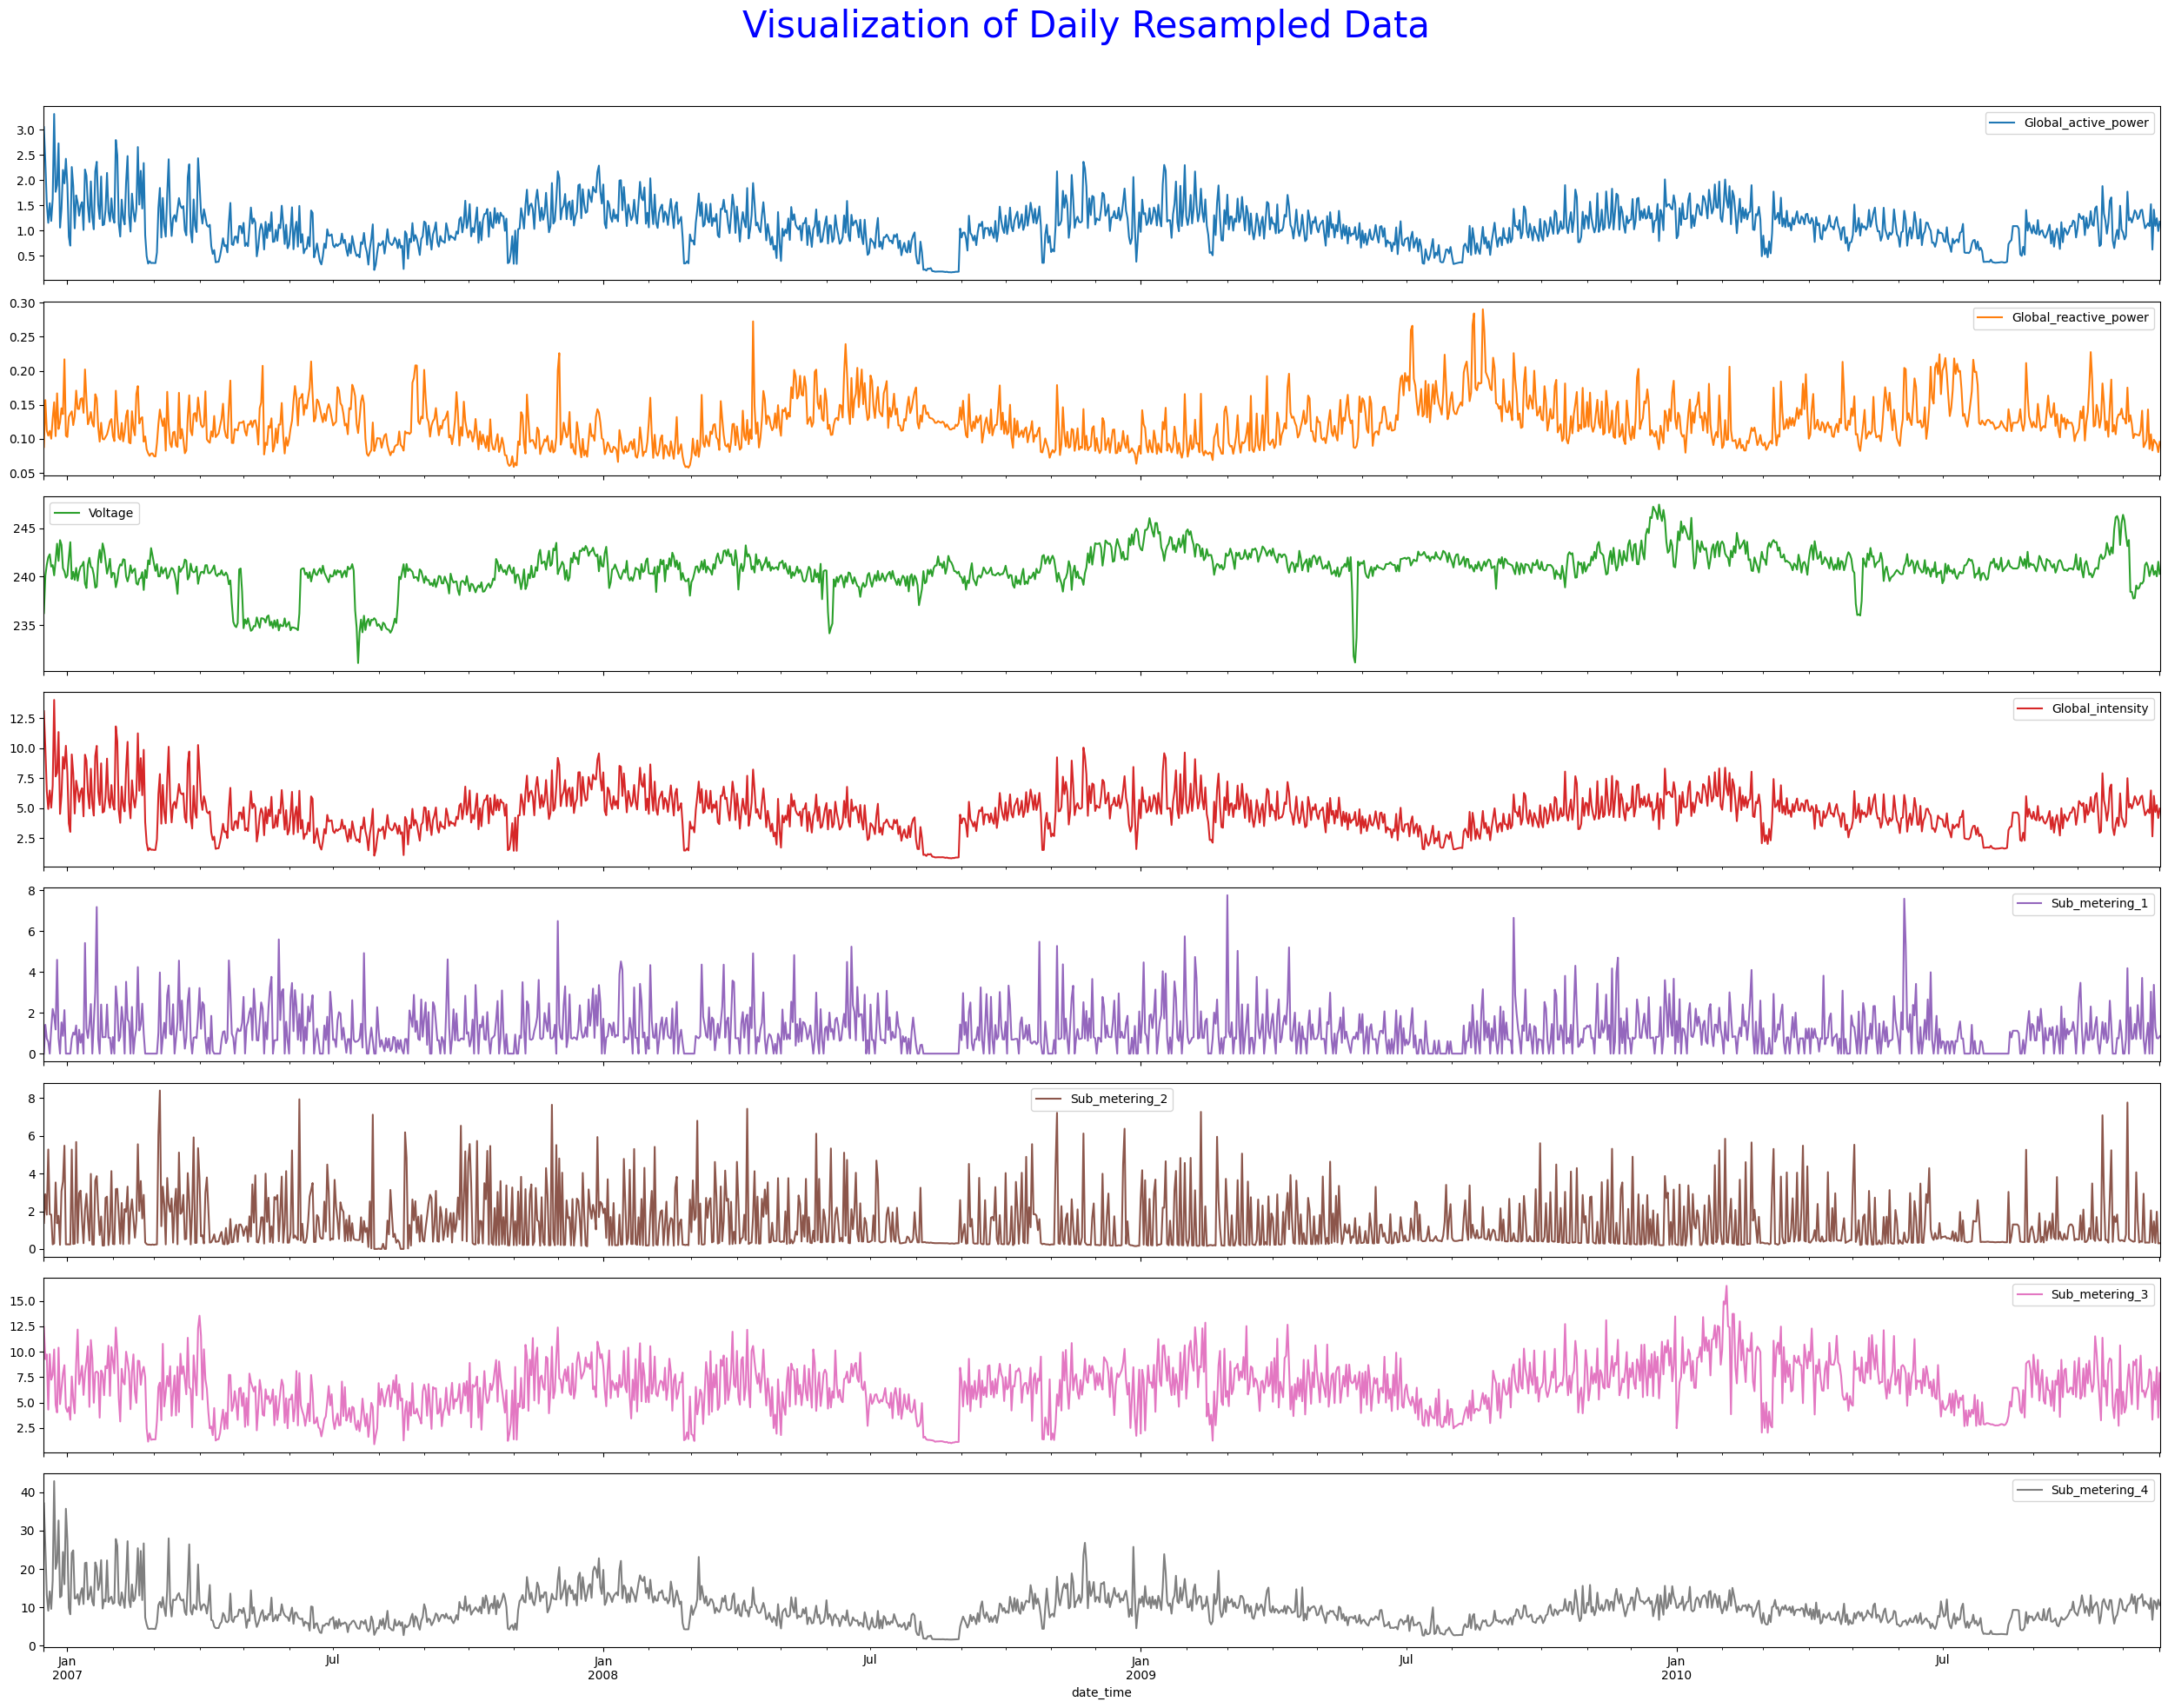

 

************************************************ Distribution Plot for Daily Resampled Data **************************************************



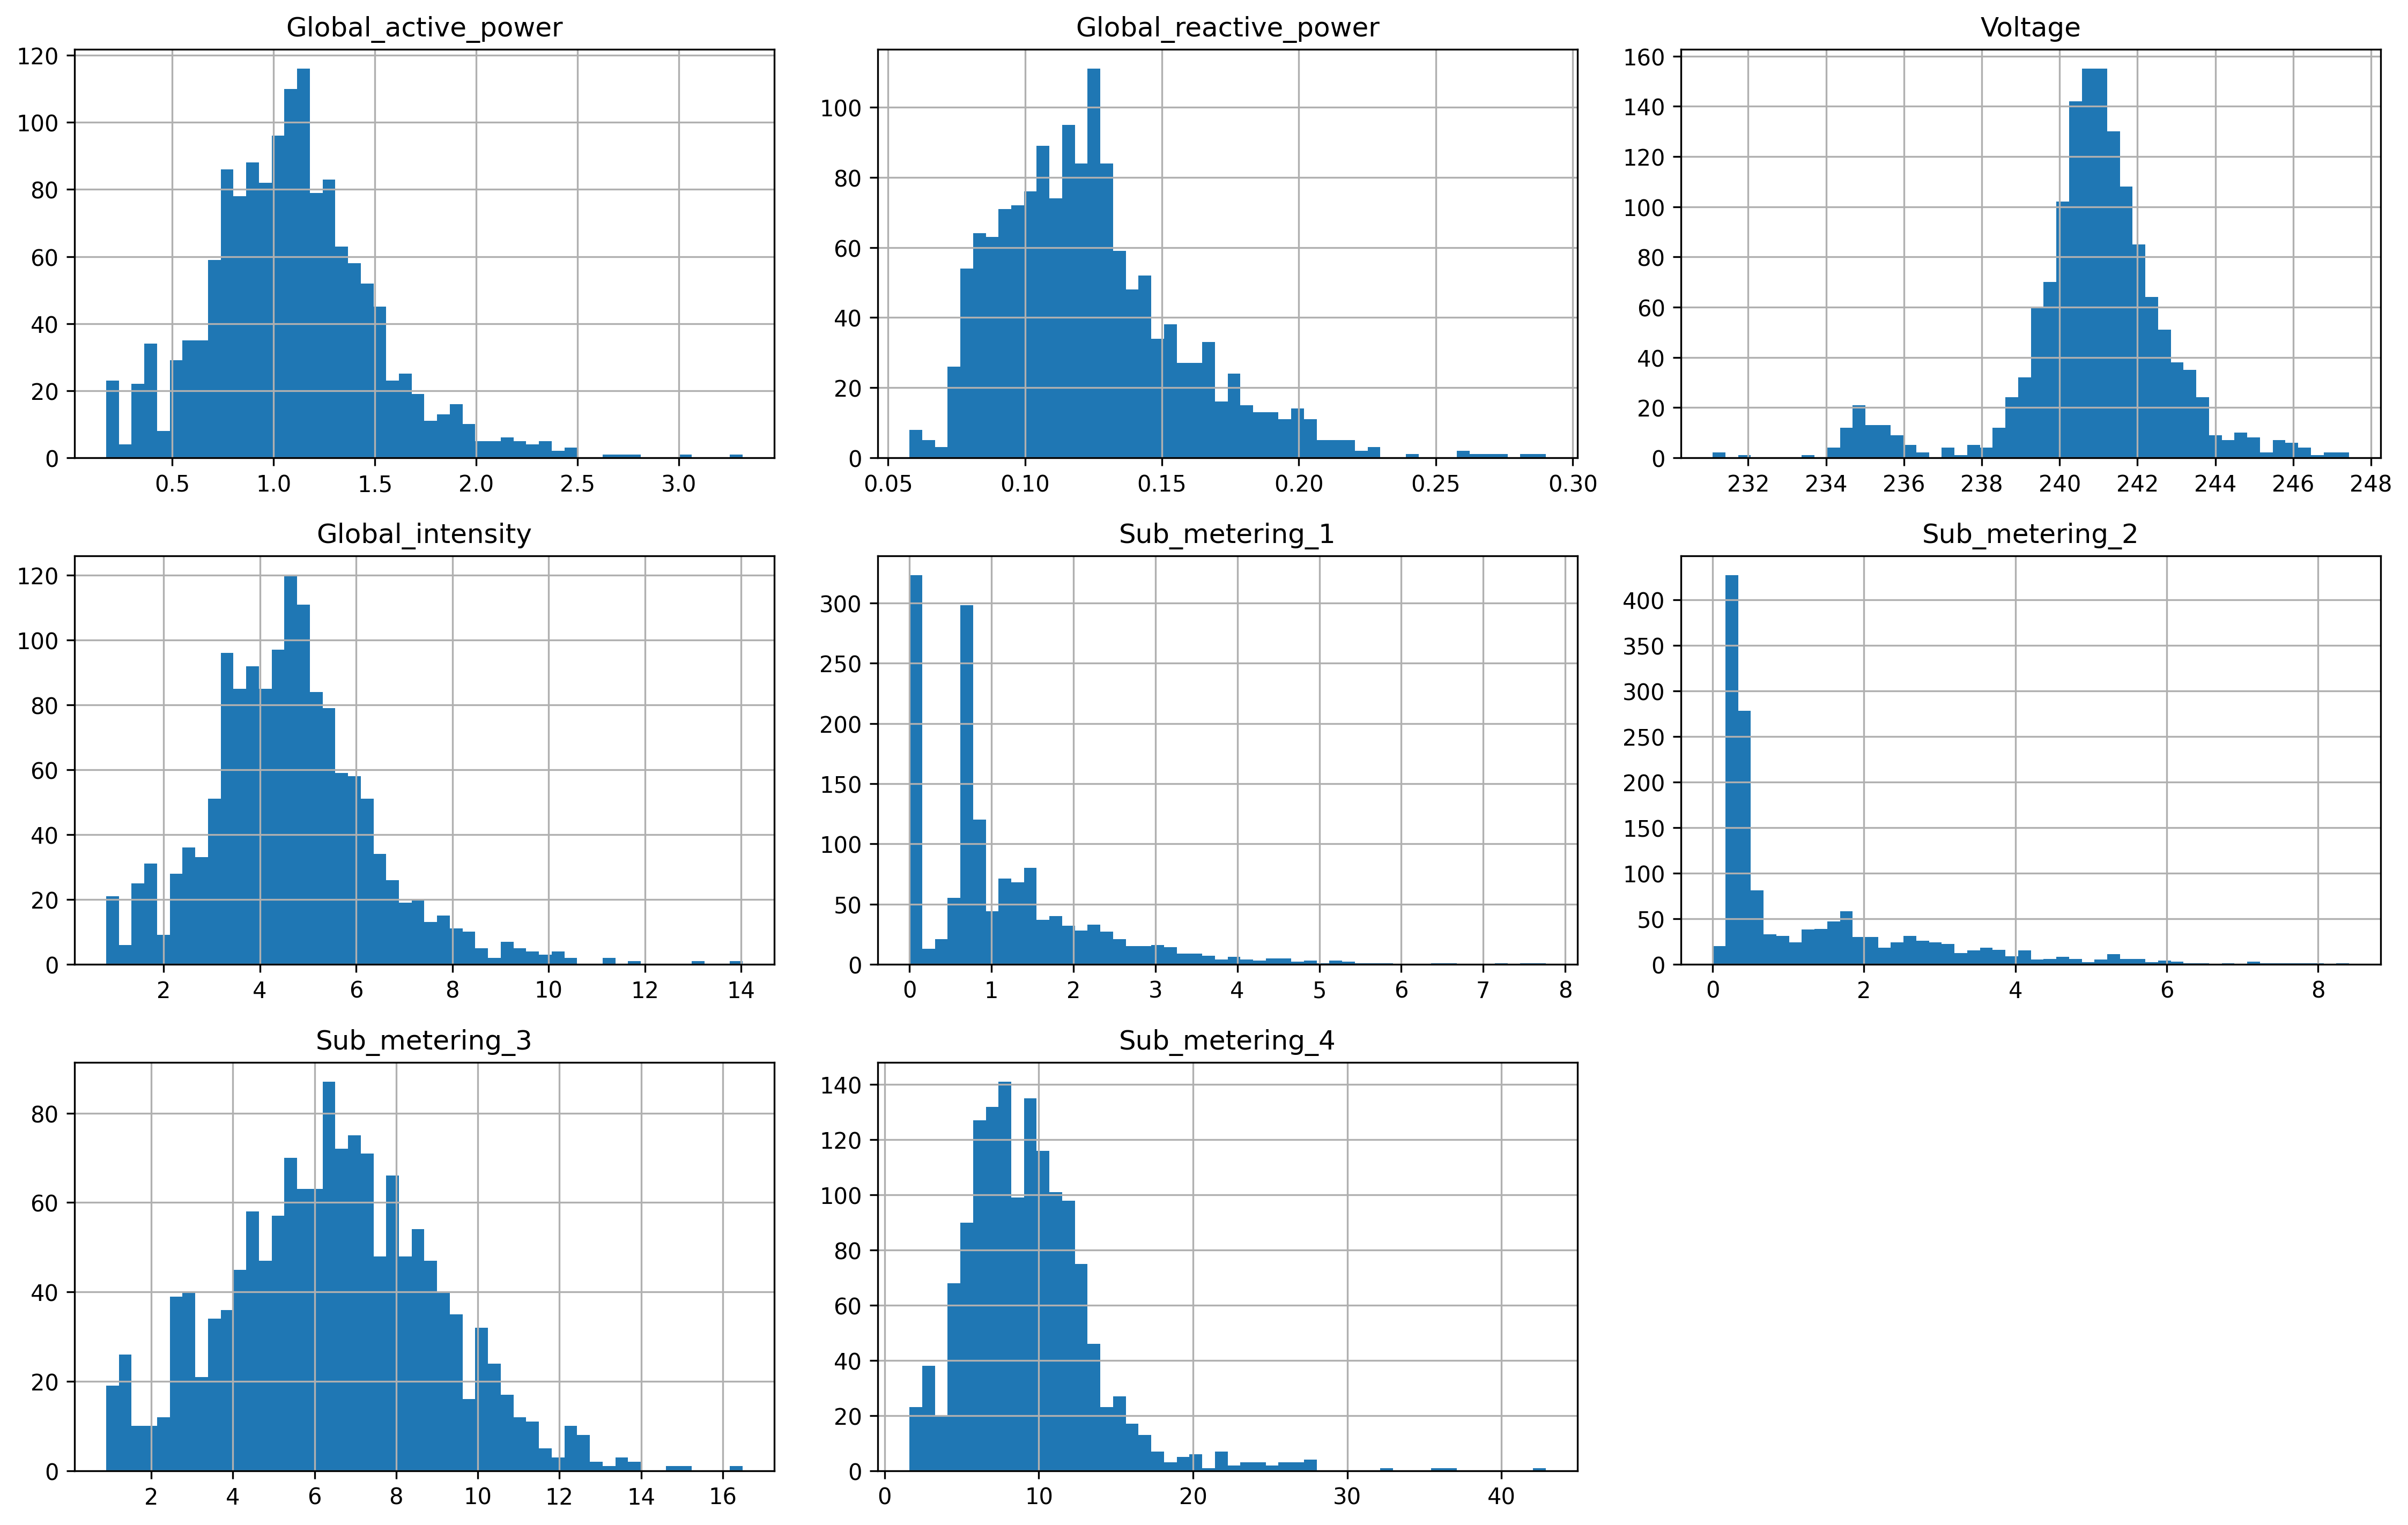

 

************************************************ Correlation Plot for Daily Resampled Data **************************************************



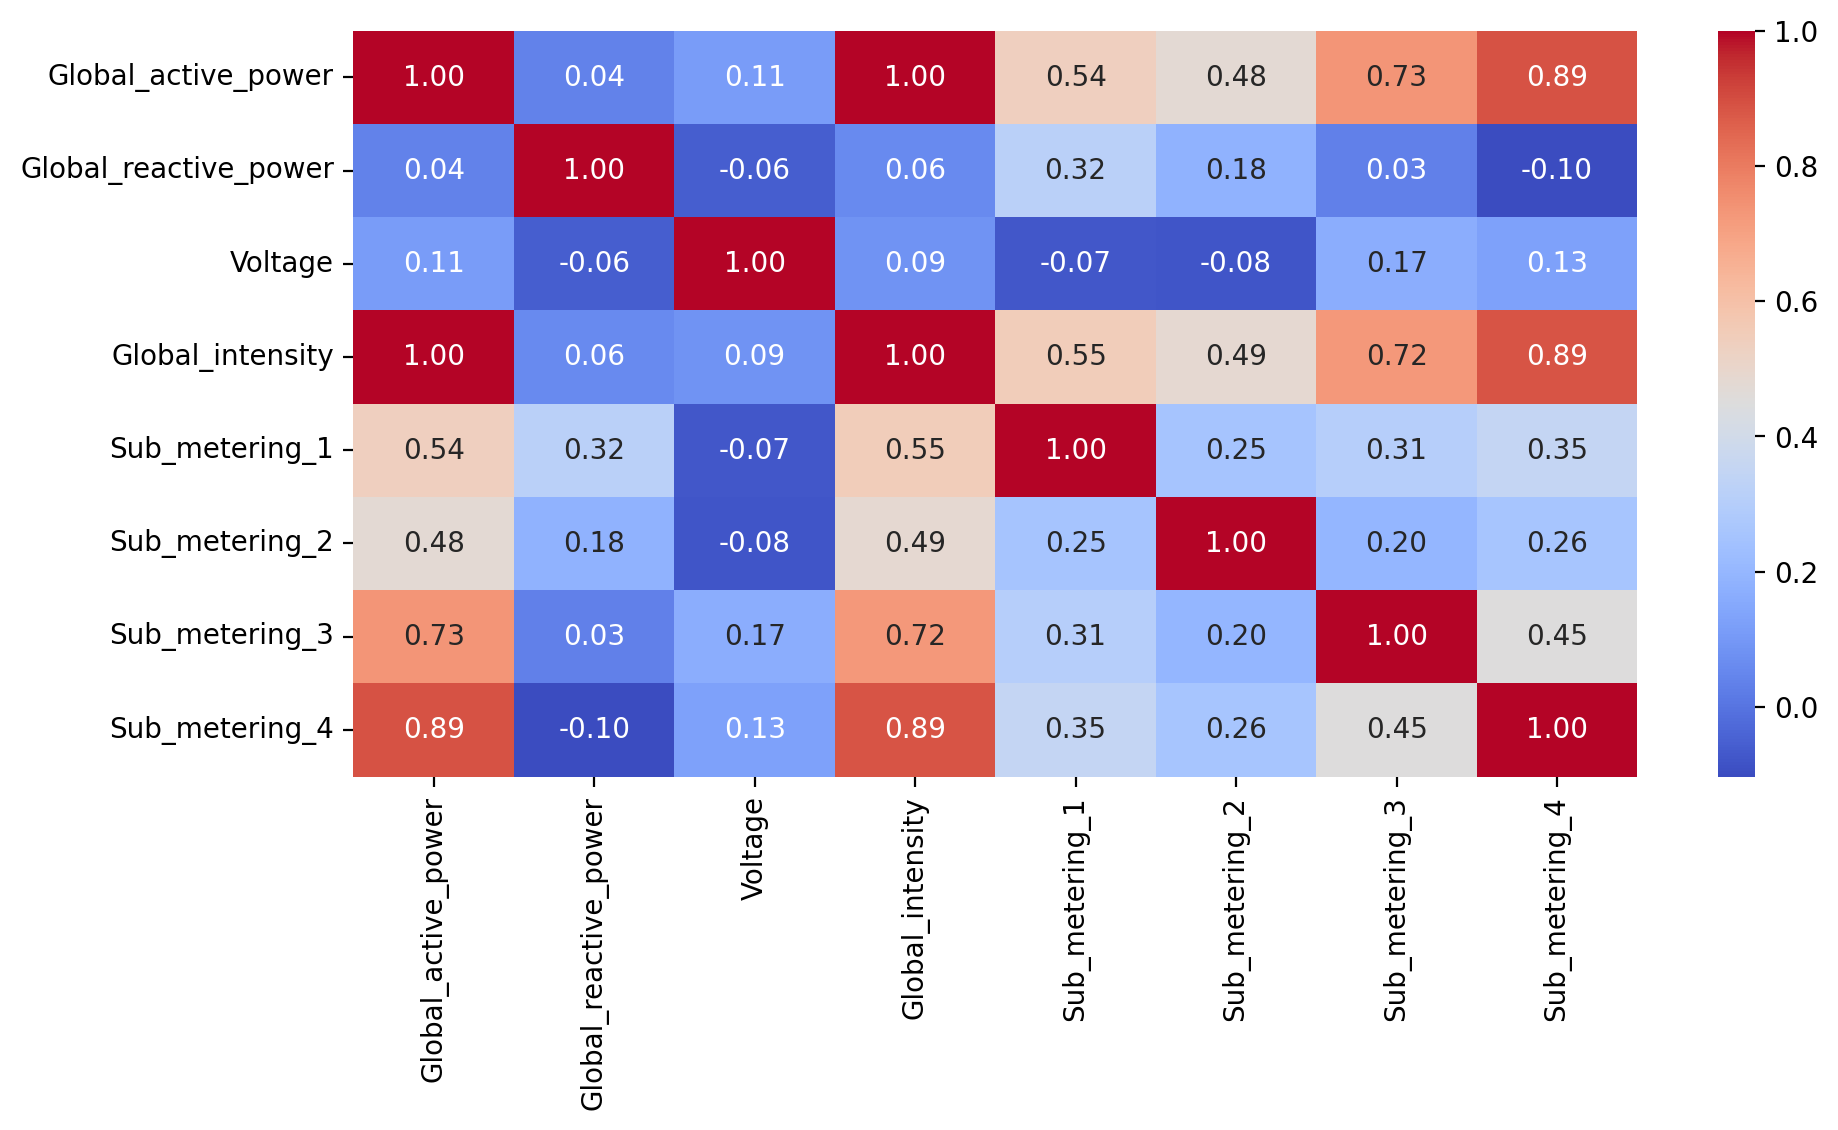

In [ ]:
# Plot the visualization, distribution and correlation of daily resampled data
df_visu_dist_corr(df_imputed, "D", "Daily")

In [ ]:
df2 = daily_resampled.drop(['Global_intensity', 'Sub_metering_4'], axis=1)

## Feature Engineering

In [ ]:
# Create new columns for hour, day, quarter, month, and year
df2['hour'] = df2.index.hour
df2['month'] = df2.index.month
df2['quarter'] = df2.index.quarter
df2['year'] = df2.index.year
df2['week_of_year'] = df2.index.isocalendar().week
df2['day_of_week'] = df2.index.dayofweek
df2['day_of_month'] = df2.index.day
df2['day_of_year'] = df2.index.dayofyear
df2

Global_active_power  Global_reactive_power     Voltage  \
date_time                                                            
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   
2006-12-19             1.157079               0.104821  241.999313   
2006-12-20             1.545658               0.111804  242.308062   
...                         ...                    ...         ...   
2010-11-22             1.417733               0.098857  240.197118   
2010-11-23             1.095511               0.095451  240.575528   
2010-11-24             1.247394               0.091986  240.030965   
2010-11-25             0.993864               0.080644  241.536257   
2010-11-26             1.178230               0.095666  240.291029   

            Sub_metering_1  Sub_metering_2  Sub_metering_3  hour  month  \
date_time                                                                 
2006-12-16        0.000000        1.378788       12.439394     0     12   
2006-12-17        1.411806        2.907639        9.264583     0     12   
2006-12-18        0.738194        1.820139        9.734722     0     12   
2006-12-19        0.582639        5.279167        4.303472     0     12   
2006-12-20        0.000000        1.838889        9.765972     0     12   
...                    ...             ...             ...   ...    ...   
2010-11-22        3.371528        1.465278        7.038889     0     11   
2010-11-23        1.299306        0.318056        5.285417     0     11   
2010-11-24        0.761111        1.977778        8.488889     0     11   
2010-11-25        0.747222        0.295833        3.522222     0     11   
2010-11-26        0.855107        0.304830        7.908947     0     11   

            quarter  year  week_of_year  day_of_week  day_of_month  \
date_time                                                            
2006-12-16        4  2006            50            5            16   
2006-12-17        4  2006            50            6            17   
2006-12-18        4  2006            51            0            18   
2006-12-19        4  2006            51            1            19   
2006-12-20        4  2006            51            2            20   
...             ...   ...           ...          ...           ...   
2010-11-22        4  2010            47            0            22   
2010-11-23        4  2010            47            1            23   
2010-11-24        4  2010            47            2            24   
2010-11-25        4  2010            47            3            25   
2010-11-26        4  2010            47            4            26   

            day_of_year  
date_time                
2006-12-16          350  
2006-12-17          351  
2006-12-18          352  
2006-12-19          353  
2006-12-20          354  
...                 ...  
2010-11-22          326  
2010-11-23          327  
2010-11-24          328  
2010-11-25          329  
2010-11-26          330  

[1442 rows x 14 columns]

In [ ]:
# Show the columns of final dataset
df2.columns, df2.shape

(Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
        'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'month',
        'quarter', 'year', 'week_of_year', 'day_of_week', 'day_of_month',
        'day_of_year'],
       dtype='object'),
 (1442, 14))

## Data Normalization

In [ ]:
# Initialize the Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns, index=df2.index)

# Shape of scaled data
scaled_df2.shape

(1442, 14)

## Train-Test Splitting

In [ ]:
# Split the data into Train & Test Split
target = ['Global_active_power']
features = scaled_df2.drop(columns=['Global_active_power']).columns

train_size = int(len(df2) * 0.80)
df2_train = scaled_df2[:train_size]
df2_test = scaled_df2[train_size:]

X_train = df2_train[features]
y_train = df2_train[target]
X_test = df2_test[features]
y_test = df2_test[target]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1153, 13), (1153, 1), (289, 13), (289, 1))

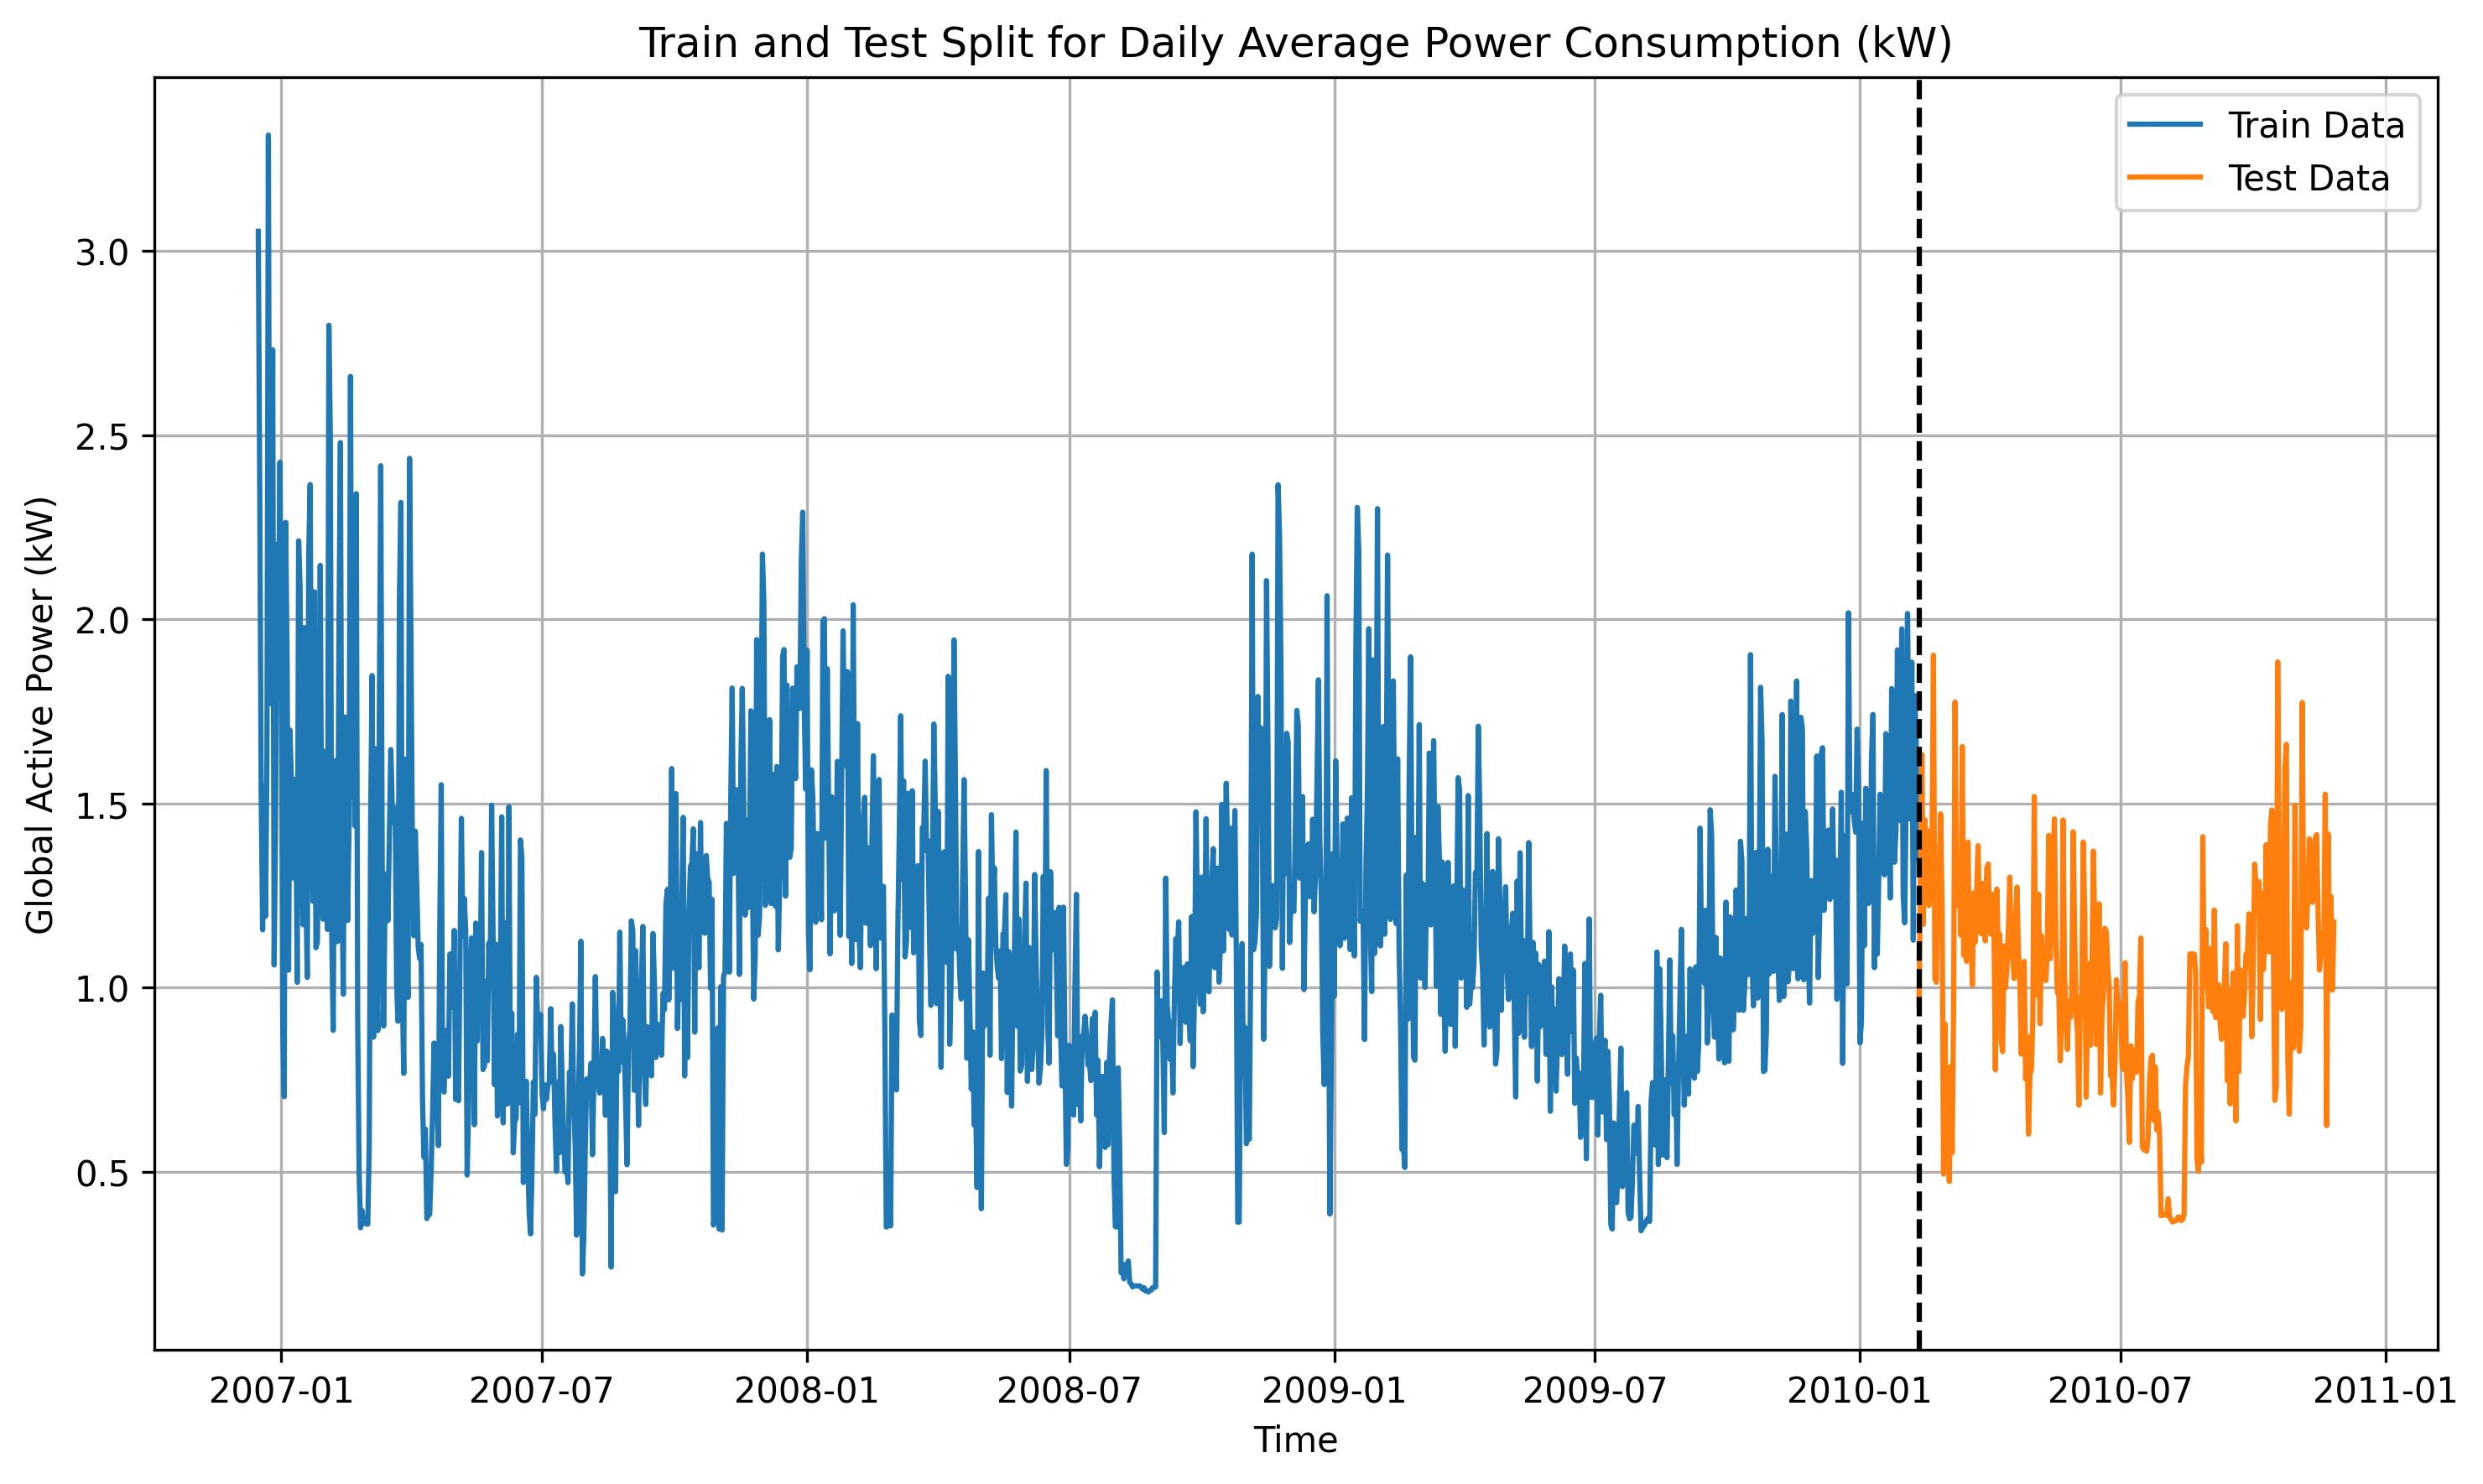

In [ ]:
# Plot train & test data
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(df2_train.Global_active_power, label='Train Data')
plt.plot(df2_test.Global_active_power, label='Test Data')
plt.axvline(df2_test.index[0], color='black', linestyle='--')
plt.title('Train and Test Split for Daily Average Power Consumption (kW)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

## Xgboost model with default parameters

[0]	validation_0-rmse:0.33571	validation_1-rmse:0.23909
[99]	validation_0-rmse:0.00820	validation_1-rmse:0.12947


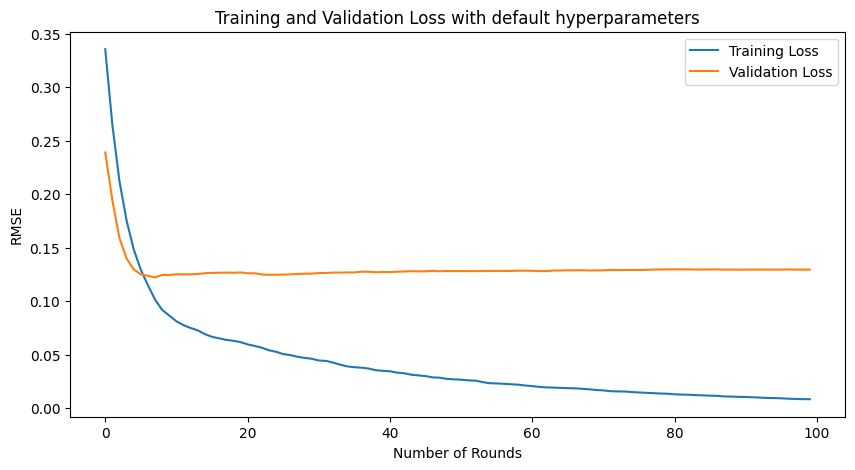


Train MAE: 0.006
Train MAPE: 0.006
Train MSE: 0.000
Train RMSE: 0.008

Test MAE: 0.101
Test MAPE: 0.105
Test MSE: 0.017
Test RMSE: 0.129


In [ ]:
# XGboost model with default parameters
xgb_model = xgb.XGBRegressor()

# Fit the XGboost model
history = xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

# Extract the evaluation results
evals_result = xgb_model.evals_result()

# Plot the training and validation loss with default parameters
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
plt.plot(evals_result['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss with default parameters')
plt.legend()
plt.show()

# Predictions with the model
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train, df2.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict.reshape(-1,1), df2.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test, df2.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for train data
test_prediction_copies = np.repeat(test_predict.reshape(-1,1), df2.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_train_y, pred_train_y):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_train_y, pred_train_y):.3f}')
print(f'Train MSE: {mean_squared_error(true_train_y, pred_train_y):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_train_y, pred_train_y)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_test_y, pred_test_y):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_test_y, pred_test_y):.3f}')
print(f'Test MSE: {mean_squared_error(true_test_y, pred_test_y):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_test_y, pred_test_y)):.3f}')

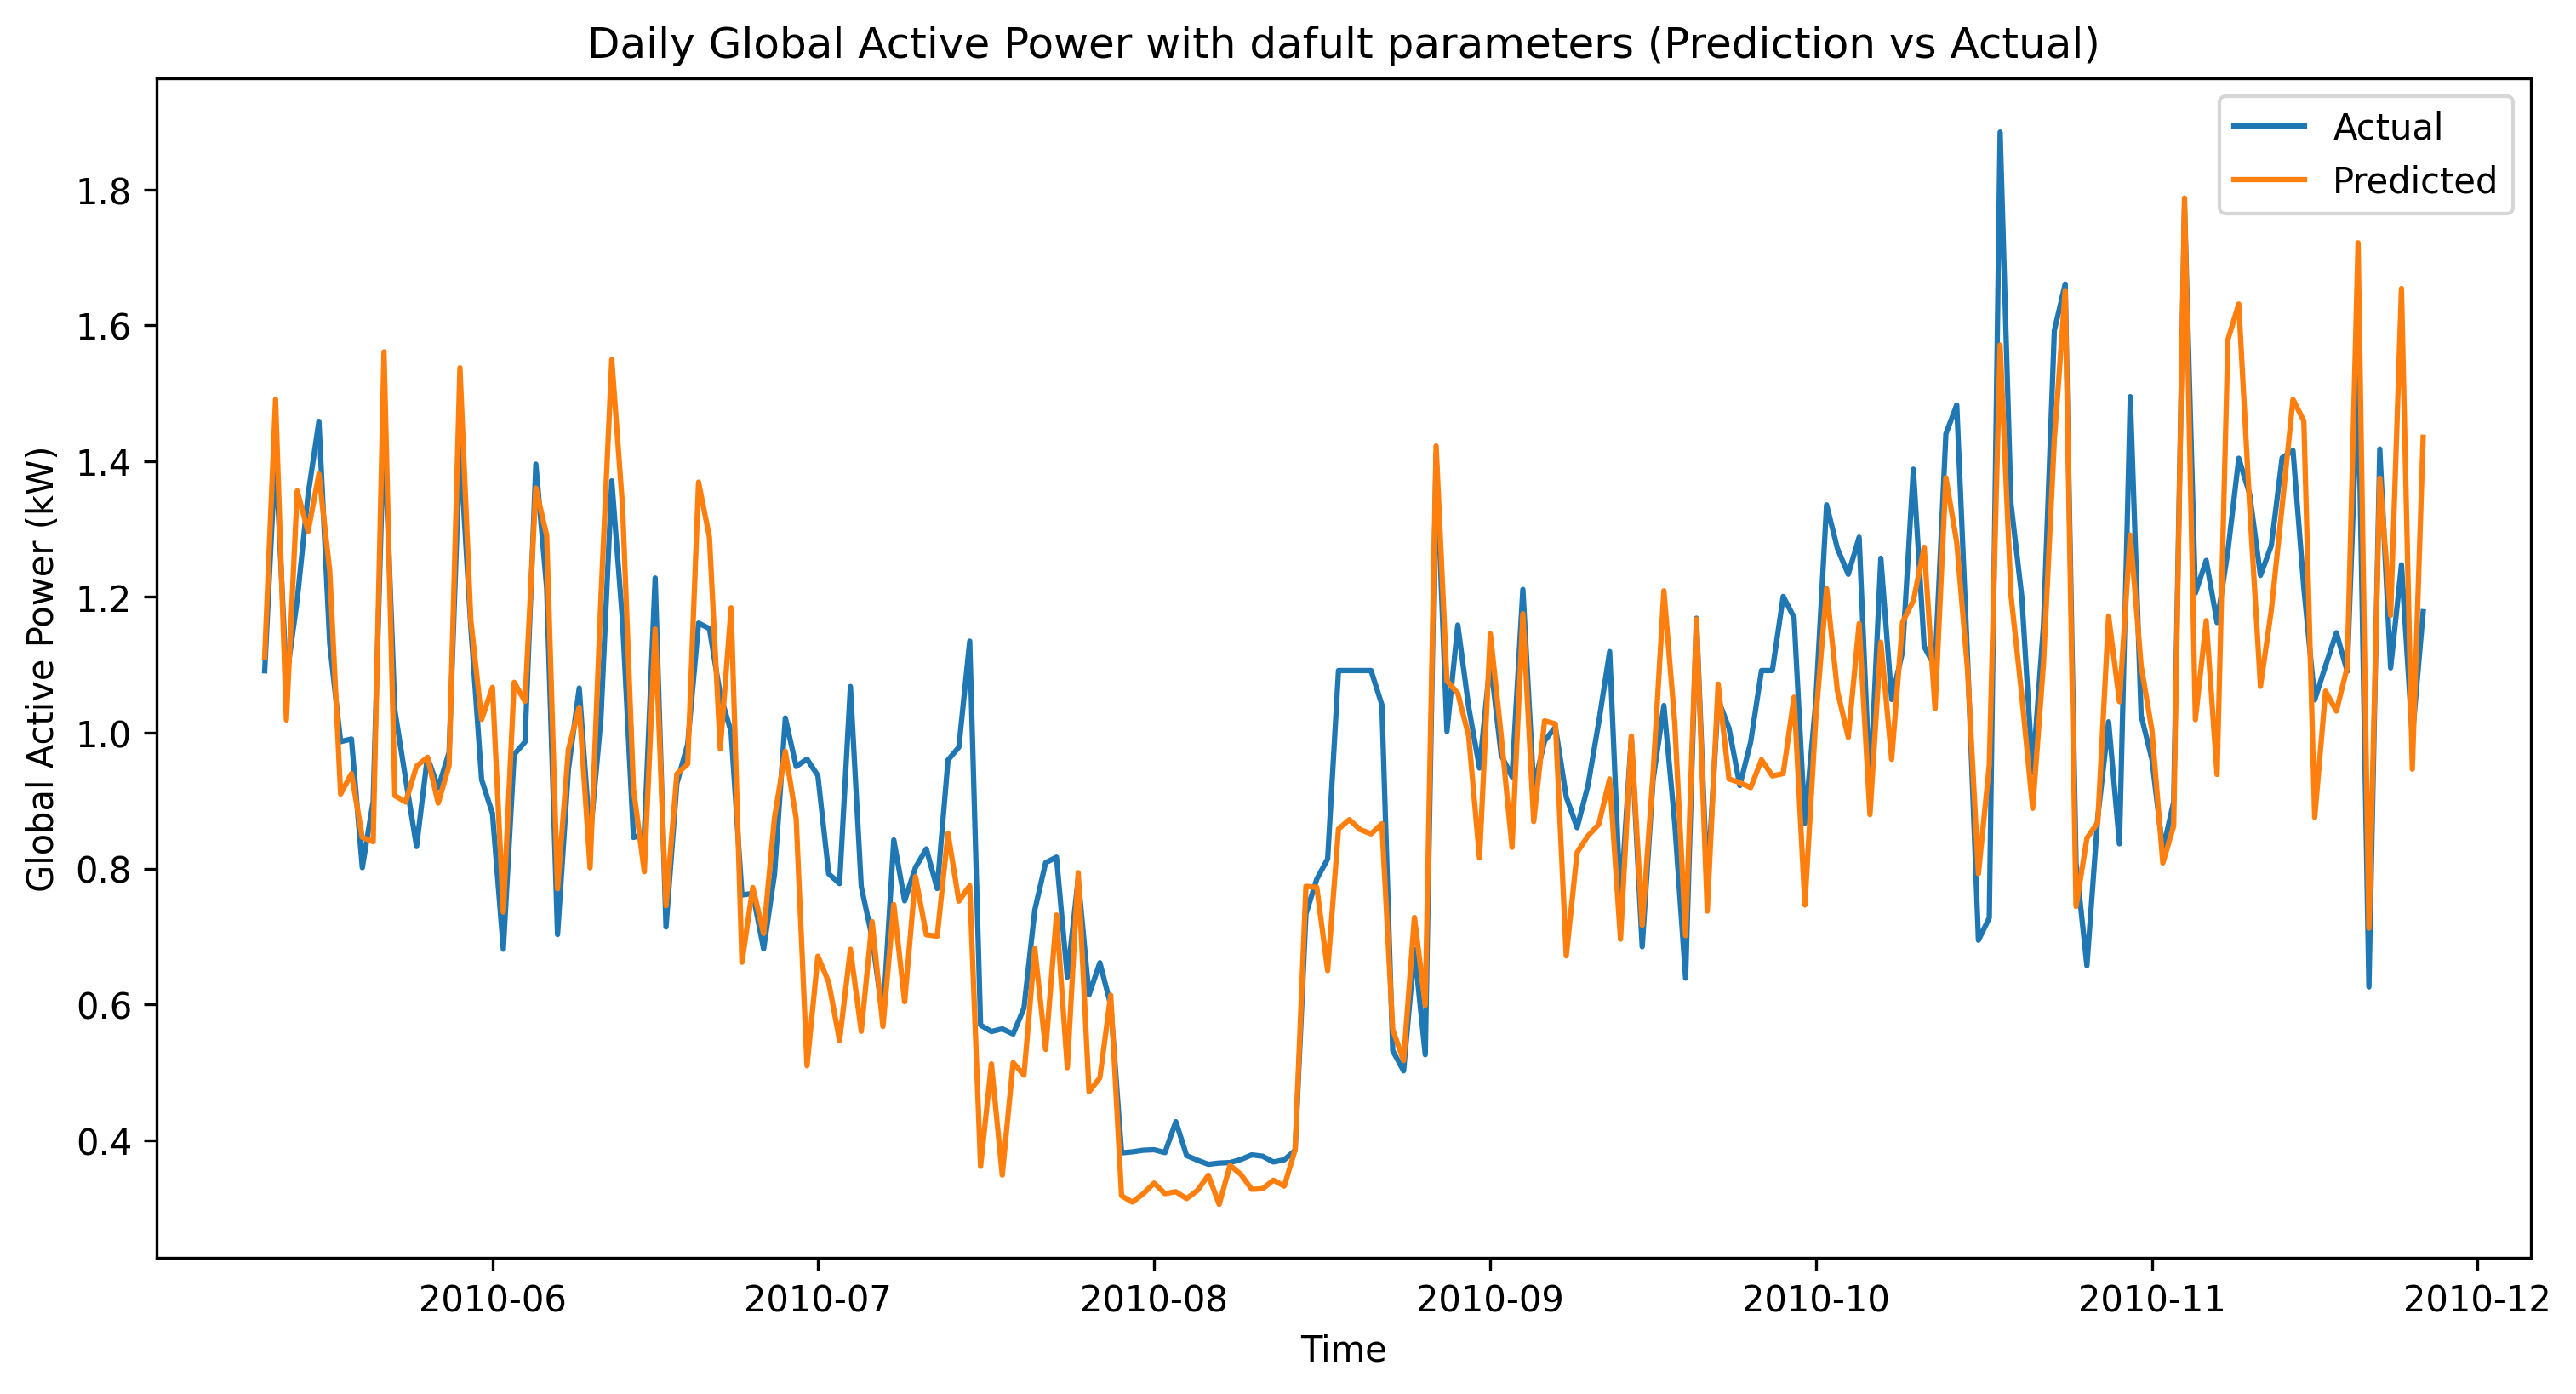

In [ ]:
# Plot the graph Actual vs Prediction
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df2.index[-200:], y_test[-200:], label='Actual')
plt.plot(df2.index[-200:], test_predict[-200:], label='Predicted')
plt.title('Daily Global Active Power with dafult parameters (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## Fine-tuing of hyperparameters

## Grid Search-1 for optimal hyperparameters

In [ ]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameters
parameters_grid = {
    'n_estimators' : [1500, 2000, 2500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [0, 1, 2],
    'subsample': [0.1, 0.2, 0.3]
    }

# Set up Grid Search
grid_search = GridSearchCV(xgb_model, parameters_grid, scoring='neg_mean_squared_error', cv=7)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 2500, 'subsample': 0.3}
Best score:  -0.0347771252680281


Best set of hyperparameters:  {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 2500, 'subsample': 0.2}
Best score:  -0.002984807239797143

## Grid Search-2 for optimal hyperparameters

In [ ]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameters
parameters_grid = {
    'base_score' : [0.06, 0.1, 0.15],
    'min_split_loss' : [0.3, 0.5, 0.9],
    'min_child_weight' : [0, 1, 1.5],
    'colsample_bytree': [0.3, 0.4],
    'reg_lambda': [0, 1, 3],
    'reg_alpha' : [0, 0.2, 0.5]
    }

# Set up Grid Search
grid_search = GridSearchCV(xgb_model, parameters_grid, scoring='neg_mean_squared_error', cv=7)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'base_score': 0.06, 'colsample_bytree': 0.4, 'min_child_weight': 0, 'min_split_loss': 0.3, 'reg_alpha': 0, 'reg_lambda': 3}
Best score:  -0.040938225866072576


## XGBoost model with optimal hyperparameters

[0]	validation_0-rmse:1.13095	validation_1-rmse:0.98324
[100]	validation_0-rmse:0.49859	validation_1-rmse:0.35322
[200]	validation_0-rmse:0.28228	validation_1-rmse:0.15497
[300]	validation_0-rmse:0.21094	validation_1-rmse:0.11515
[400]	validation_0-rmse:0.18267	validation_1-rmse:0.11131
[500]	validation_0-rmse:0.16906	validation_1-rmse:0.11175
[600]	validation_0-rmse:0.16135	validation_1-rmse:0.11230
[700]	validation_0-rmse:0.15673	validation_1-rmse:0.11292
[800]	validation_0-rmse:0.15460	validation_1-rmse:0.11345
[900]	validation_0-rmse:0.15309	validation_1-rmse:0.11372
[1000]	validation_0-rmse:0.15181	validation_1-rmse:0.11411
[1100]	validation_0-rmse:0.15058	validation_1-rmse:0.11386
[1200]	validation_0-rmse:0.14959	validation_1-rmse:0.11397
[1300]	validation_0-rmse:0.14902	validation_1-rmse:0.11398
[1400]	validation_0-rmse:0.14857	validation_1-rmse:0.11447
[1453]	validation_0-rmse:0.14837	validation_1-rmse:0.11451


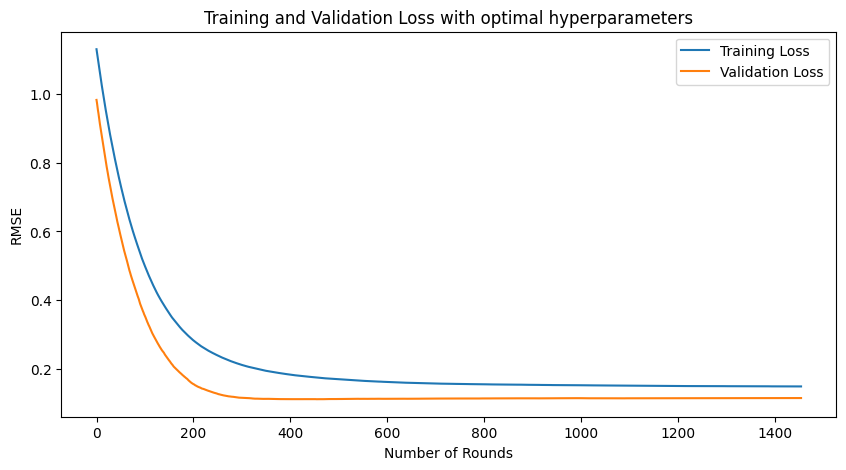


Train MAE: 0.113
Train MAPE: 0.123
Train MSE: 0.030
Train RMSE: 0.174

Test MAE: 0.091
Test MAPE: 0.107
Test MSE: 0.012
Test RMSE: 0.111


In [ ]:
# Define the XGBoost model with differnt hyperparameters
xgb_model = xgb.XGBRegressor(booster='gbtree',
                             objective='reg:linear',
                             early_stopping_rounds=200,
                             learning_rate=0.01,        # [default=0.3] range: [0,1]
                             max_depth=2,               # [default=6] range: [0,∞]
                             n_estimators=2500,
                             subsample=0.3,             # [default=1] range: [0,1]
                             base_score=0.06,
                             colsample_bytree=0.4,      # [default=1] range: [0,1]
                             min_child_weight=0,        # [default=1] range: [0,∞]
                             min_split_loss=0.3,        # [default=0] range: [0,∞]
                             reg_alpha=0,               # [default=0] range: [0,∞]
                             reg_lambda=3)              # [default=1] range: [0,∞]

# Fit the XGboost model
history = xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

# Extract the evaluation results
evals_result = xgb_model.evals_result()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
plt.plot(evals_result['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss with optimal hyperparameters')
plt.legend()
plt.show()

# Predictions with the fine-turned  model
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train, scaled_df2.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict.reshape(-1,1), df2.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test, df2.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for train data
test_prediction_copies = np.repeat(test_predict.reshape(-1,1), df2.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_train_y, pred_train_y):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_train_y, pred_train_y):.3f}')
print(f'Train MSE: {mean_squared_error(true_train_y, pred_train_y):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_train_y, pred_train_y)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_test_y, pred_test_y):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_test_y, pred_test_y):.3f}')
print(f'Test MSE: {mean_squared_error(true_test_y, pred_test_y):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_test_y, pred_test_y)):.3f}')

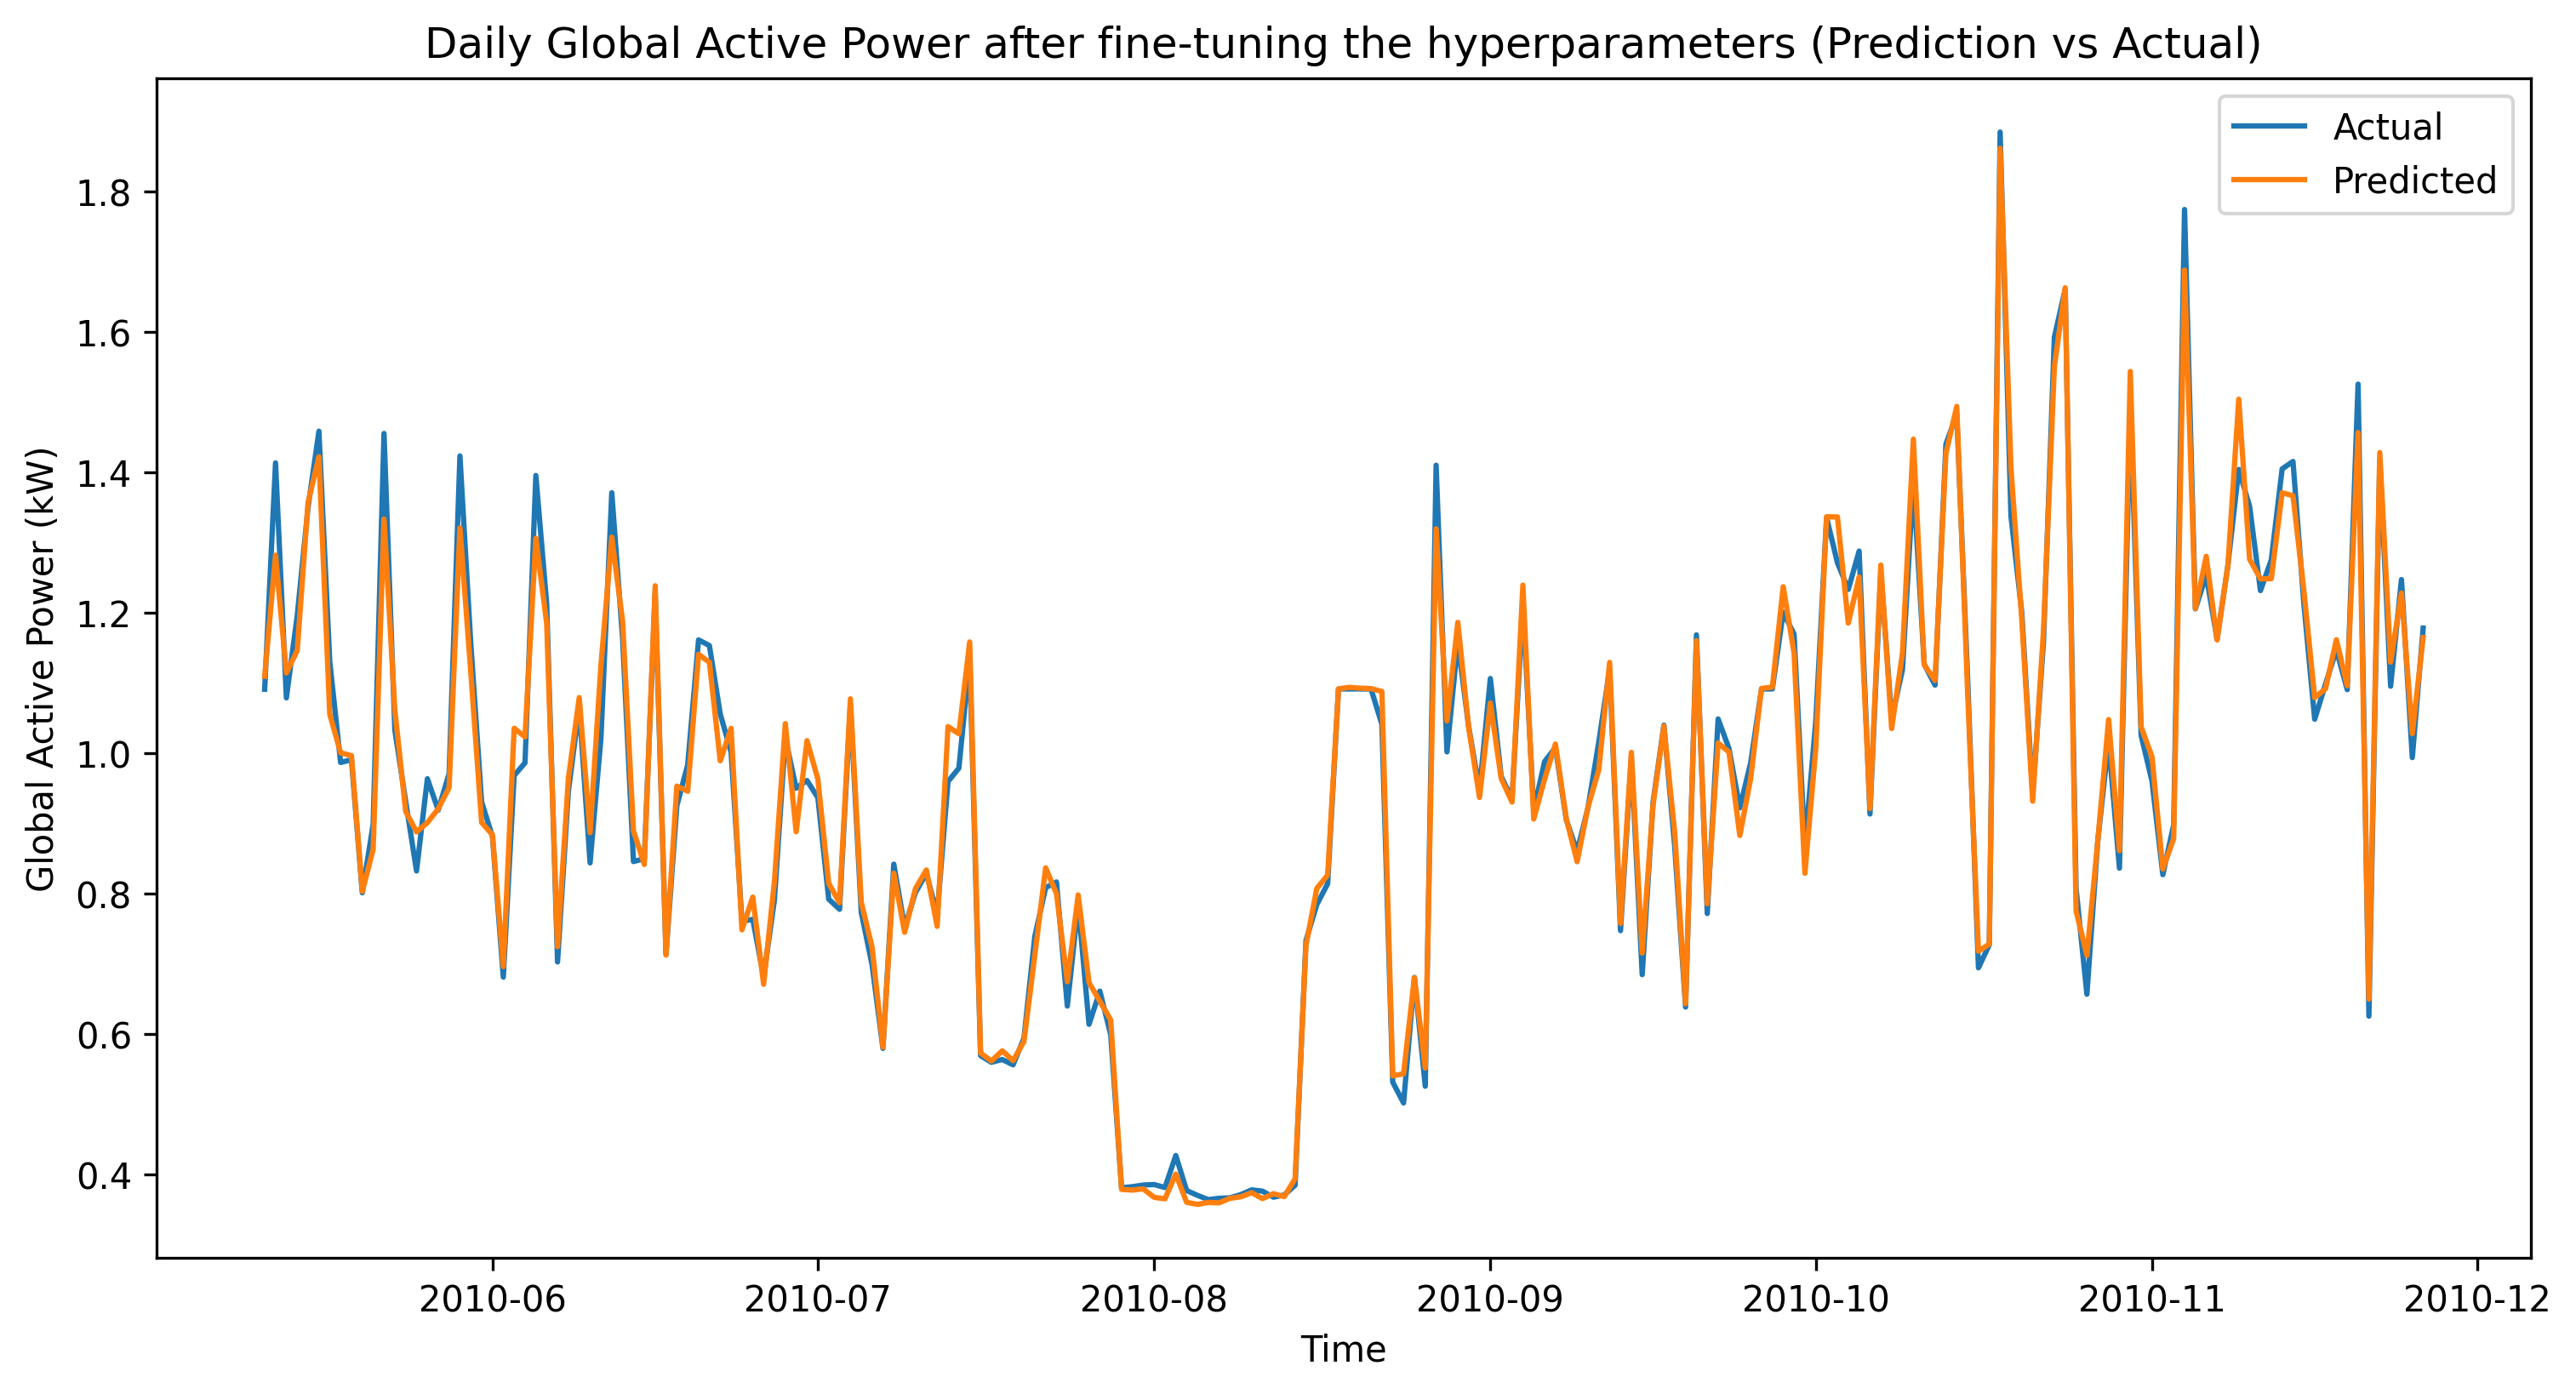

In [ ]:
# Plot the graph after fine-tuning the hyperparameters (Actual vs Prediction)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df2.index[-200:], y_test[-200:], label='Actual')
plt.plot(df2.index[-200:], test_predict[-200:], label='Predicted')
plt.title('Daily Global Active Power after fine-tuning the hyperparameters')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## Feature Importance

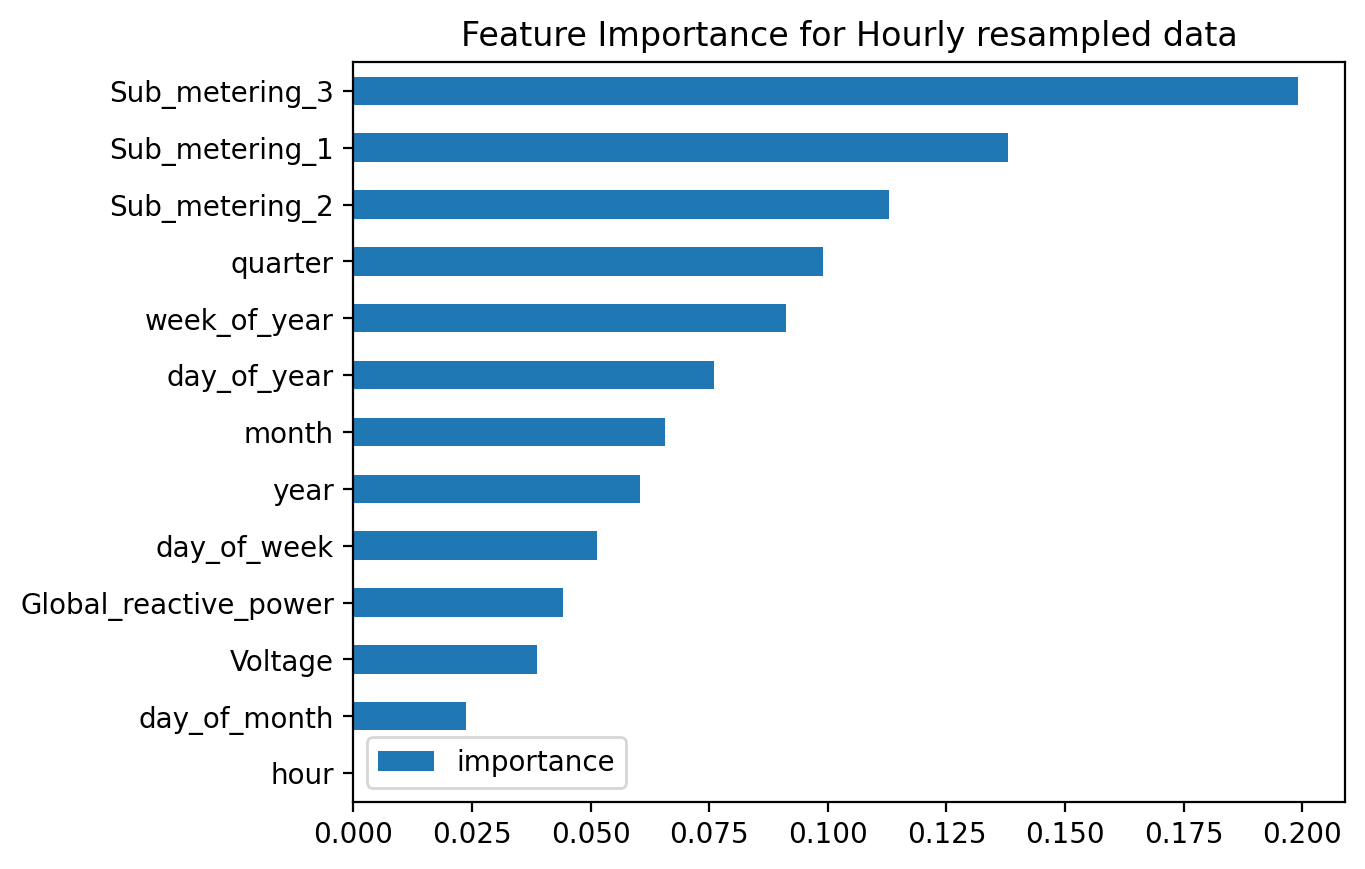

In [ ]:
# Feature Importance of XGBoost model
Feature_Imp = pd.DataFrame(data=xgb_model.feature_importances_,
                           index=xgb_model.feature_names_in_,
                           columns=['importance'])
Feature_Imp.sort_values('importance').plot(kind='barh', title='Feature Importance for Hourly resampled data')

# Plot the feature importance
plt.gcf().set_dpi(200)
plt.show()